In [1]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import Dataset as HFDataset
from PIL import Image
import json
import os
from tqdm import tqdm
import torch
import os

# Set CUDA environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

class ChartDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, processor):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.processor = processor
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return min(5000,len(self.image_files))

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        annotation_file = image_file.replace('.jpg', '.json')

        # Load image
        image_path = os.path.join(self.images_dir, image_file)
        image = Image.open(image_path).convert("RGB")

        # Load annotation
        annotation_path = os.path.join(self.annotations_dir, annotation_file)
        with open(annotation_path, 'r') as f:
            annotation = json.load(f)

        # Extract data-series from annotation
        data_series = annotation.get("data-series", [])
        for entry in data_series:
            entry["y"] = round(float(entry["y"]), 4)  # Ensure y has 4 decimal places

            
        # Preprocess the image with the text "Generate data series"
        inputs = self.processor(images=image, text="Generate data series:", return_tensors="pt")

        return {
            "flattened_patches": inputs["flattened_patches"].squeeze(),
            "labels": torch.tensor(self.processor.tokenizer(json.dumps(data_series), padding="max_length", max_length=512, truncation=True).input_ids)  # Reduced max_length
        }

# Custom data collator
def custom_data_collator(features):
    flattened_patches = torch.stack([feature["flattened_patches"] for feature in features])
    labels = torch.nn.utils.rnn.pad_sequence([feature["labels"] for feature in features], batch_first=True, padding_value=-100)
    return {"flattened_patches": flattened_patches, "labels": labels}

# Paths to your data directories
images_dir = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/line/images"
annotations_dir = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/line/annotations"

# Load processor and model
model = Pix2StructForConditionalGeneration.from_pretrained("google/deplot")
processor = AutoProcessor.from_pretrained("google/deplot")

# Prepare dataset
dataset = ChartDataset(images_dir, annotations_dir, processor)

# Split dataset into training and evaluation
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Use DataLoader for lazy loading and batching
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [2]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/deplot_finetuned",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,  # Further reduced batch size
    per_device_eval_batch_size=1,  # Further reduced batch size
    num_train_epochs=5,
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,
    logging_dir="/kaggle/working/logs",
    logging_steps=200,
    push_to_hub=False,
    dataloader_num_workers=2,  # Reduced workers
    ddp_find_unused_parameters=False,
    report_to=["none"],
    gradient_accumulation_steps=2,  # Reduced gradient accumulation
    no_cuda=False,
    load_best_model_at_end=True
)

In [3]:
# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=eval_dataset,    # Evaluation dataset
    tokenizer=processor.tokenizer,
    data_collator=custom_data_collator
)

# Train model
trainer.train()

# Save the model
model.save_pretrained("/kaggle/working/deplot_line_finetuned")
processor.save_pretrained("/kaggle/working/deplot_line_finetuned")

<ipython-input-3-13a71d24af1c>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, If both images and text are provided, image_processor is not a VQA processor, and `add_special_tokens` is unset, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer. To test the new behavior, set `legacy=False`as a processor call argument.
Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, If both images and text are provided, image_processor is not a VQA processor, and `add_special_tokens` is unset, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer. To test the new behavior, set `legacy=False`as a processor call argument.


Arial.TTF:   0%|          | 0.00/276k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, If both images and text are provided, image_processor is not a VQA processor, and `add_special_tokens` is unset, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer. To test the new behavior, set `legacy=False`as a processor call argument.
Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, If both images and text are provided, image_processor is not a VQA processor, and `add_special_tokens` is unset, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer. To test the new behavior, set `legacy=False`as a processor call argument.
Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, If both images and text are provided, image_processor is not a VQA processor, and `add_special_tokens`

[]

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
import os
import torch
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/working/deplot_line_finetuned").to(device)
processor = AutoProcessor.from_pretrained("/kaggle/working/deplot_line_finetuned")

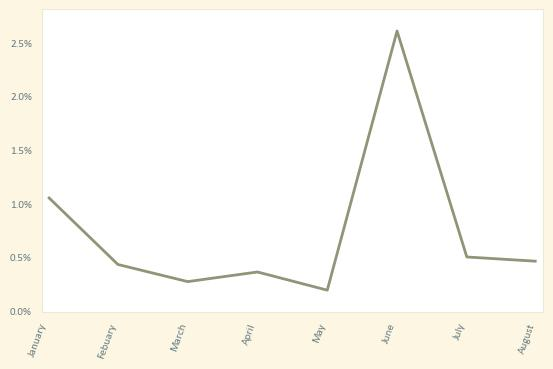

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, If both images and text are provided, image_processor is not a VQA processor, and `add_special_tokens` is unset, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer. To test the new behavior, set `legacy=False`as a processor call argument.


[{"x": "January", "y": 10.8279}, {"x": "February", "y": 0.4869}, {"x": "March", "y": 0.2959}, {"x": "April", "y": 0.3659}, {"x": "Mar", "y": 0.2199}, {"x": "June", "y": 25.1299}, {"x": "July", "y": 0.6312}, {"x": "August", "y": 0.4651}]


In [5]:
# Load an example image for prediction
image_path = "/kaggle/input/benetech-extra-generated-data/graphs_l/84359.jpg"
image = Image.open(image_path)
display(image)

inputs = processor(images=image, text="Generate data series:", return_tensors="pt")

# Move inputs to GPU
inputs = {key: value.to(device) for key, value in inputs.items()}

predictions = model.generate(**inputs, max_new_tokens=2048)
print(processor.decode(predictions[0], skip_special_tokens=True))

start loop:


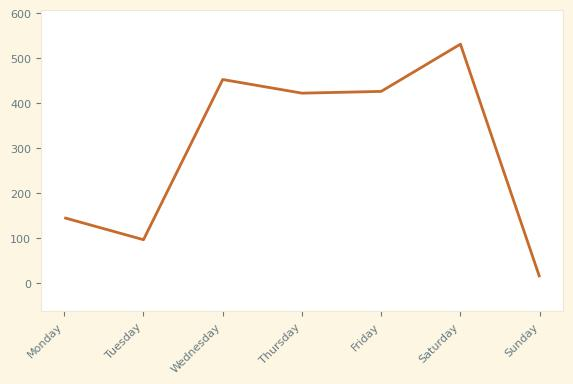

[{"x": "Monday", "y": 147.5322}, {"x": "Tuesday", "y": 100.6322}, {"x": "Wednesday", "y": 455.1222}, {"x": "Thursday", "y": 427.0562}, {"x": "Friday", "y": 428.0562}, {"x": "Saturday", "y": 530.0562}, {"x": "Sunday", "y": 11.0078}]


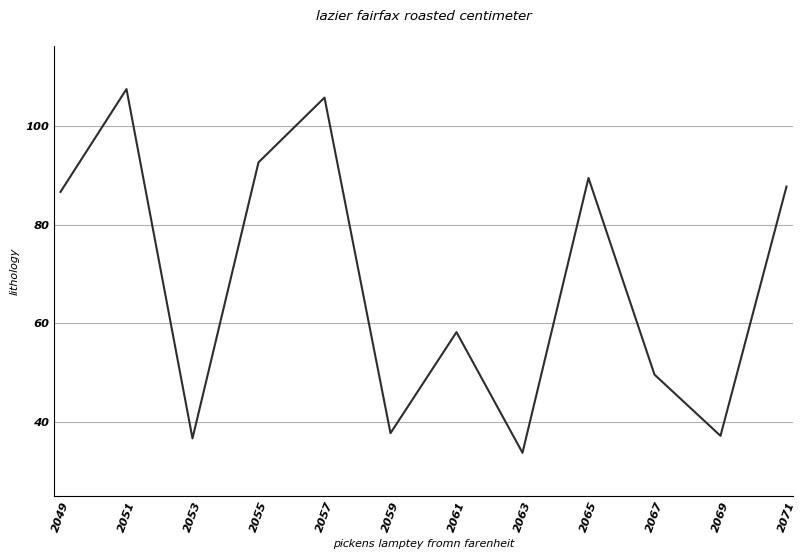

[{"x": "2000", "y": 86.4555}, {"x": "2001", "y": 106.3555}, {"x": "2002", "y": 38.9555}, {"x": "2003", "y": 93.2555}, {"x": "2004", "y": 105.6555}, {"x": "2005", "y": 105.8555}, {"x": "2006", "y": 95.8555}, {"x": "2007", "y": 50.5555}, {"x": "2008", "y": 38.2055}, {"x": "2009", "y": 87.5055}]


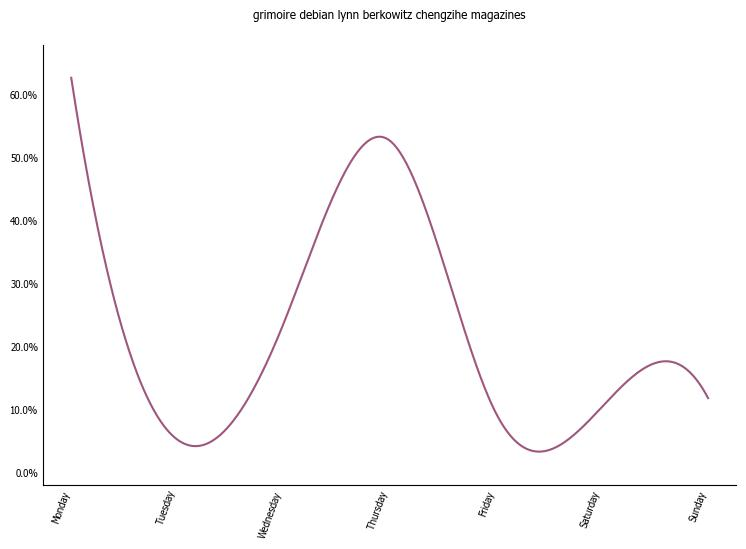

[{"x": "Morocco", "y": 6.0999}, {"x": "Turkmeni", "y": 0.0999}, {"x": "Madagascar", "y": 2.0999}, {"x": "Tanzania", "y": 5.0999}, {"x": "Frew", "y": 10.0999}, {"x": "Senegal", "y": 9.0899}, {"x": "Slovakia", "y": 10.0899}]


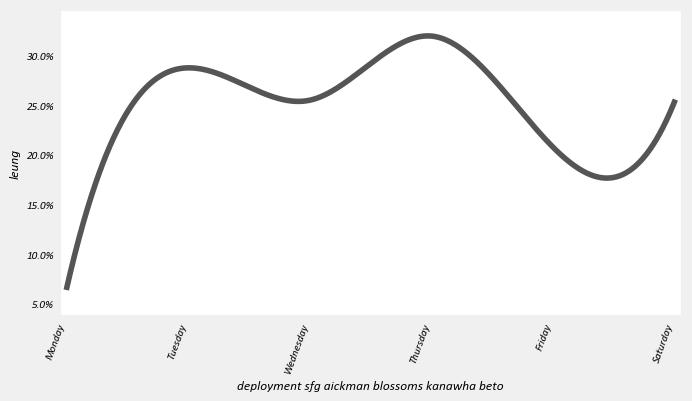

[{"x": "Monday", "y": 5.0563}, {"x": "Tuesday", "y": 28.8829}, {"x": "Wednesday", "y": 25.0603}, {"x": "Tuesday", "y": 30.0693}, {"x": "Friday", "y": 20.0861}, {"x": "Saturday", "y": 25.0603}]


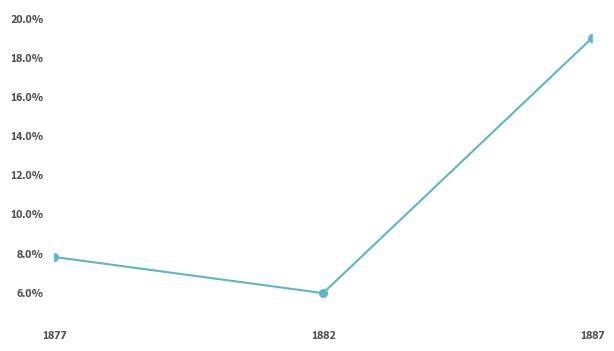

[{"x": "1877", "y": 79.7821}, {"x": "1882", "y": 60.5021}, {"x": "1887", "y": 19.0921}]


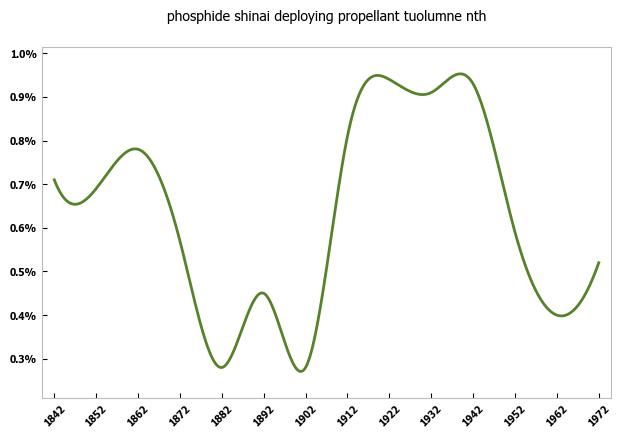

[{"x": "1940", "y": 0.7082}, {"x": "1952", "y": 0.698}, {"x": "1962", "y": 0.7782}, {"x": "1972", "y": 0.5642}, {"x": "1982", "y": 0.3282}, {"x": "1992", "y": 0.4482}, {"x": "1992", "y": 0.3202}, {"x": "1993", "y": 0.8078}, {"x": "1992", "y": 0.9462}, {"x": "1992", "y": 0.9129}, {"x": "1990", "y": 0.9429}, {"x": "1962", "y": 0.5692}, {"x": "1962", "y": 0.3992}, {"x": "1972", "y": 0.5211}]


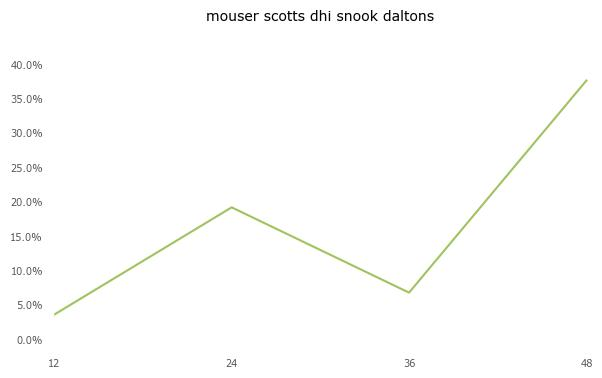

[{"x": "12", "y": 4.0}, {"x": "24", "y": 19.0}, {"x": "36", "y": 7.0}, {"x": "48", "y": 38.0}]


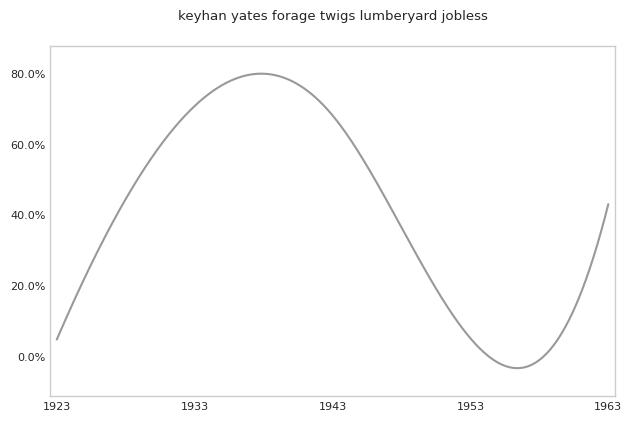

[{"x": "1923", "y": 0.005}, {"x": "1933", "y": 71.925}, {"x": "1943", "y": 66.005}, {"x": "1953", "y": 0.005}, {"x": "1963", "y": 44.005}]


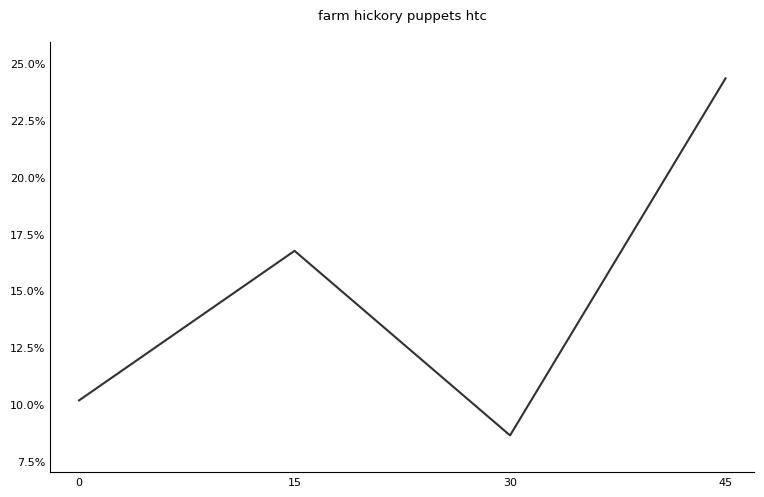

[{"x": "0", "y": 10.2722}, {"x": "15", "y": 16.7822}, {"x": "30", "y": 8.7621}, {"x": "45", "y": 24.3871}]


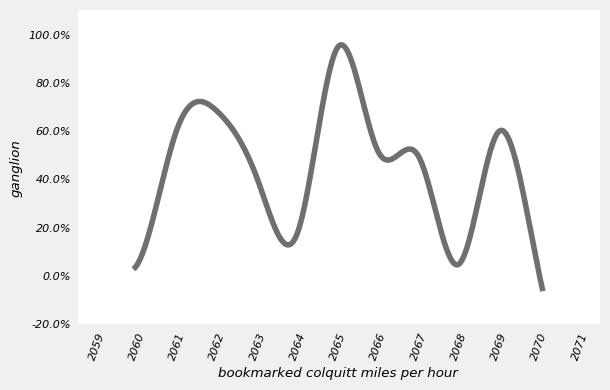

[{"x": "2009", "y": -2.0}, {"x": "2060", "y": -1.0}, {"x": "2061", "y": 62.0}, {"x": "2062", "y": 68.0}, {"x": "2063", "y": 40.0}, {"x": "2064", "y": 17.0}, {"x": "2065", "y": 96.0}, {"x": "2066", "y": 50.0}, {"x": "2067", "y": 48.0}, {"x": "2068", "y": 10.0}, {"x": "2069", "y": 60.0}, {"x": "2070", "y": -1.0}, {"x": "2071", "y": -1.0}]


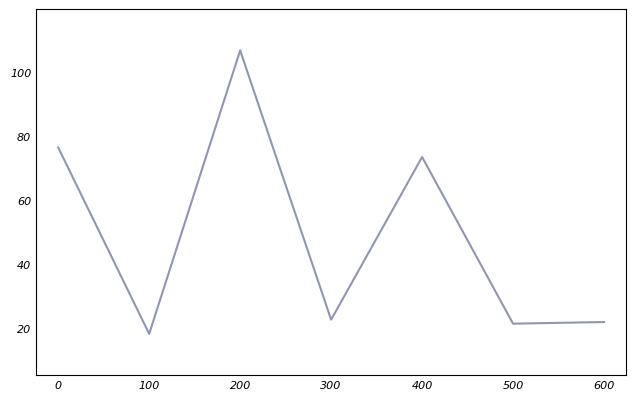

[{"x": "0", "y": 76.6321}, {"x": "100", "y": 19.6321}, {"x": "200", "y": 105.5552}, {"x": "300", "y": 24.2055}, {"x": "400", "y": 73.2555}, {"x": "500", "y": 22.0055}, {"x": "600", "y": 22.0055}]


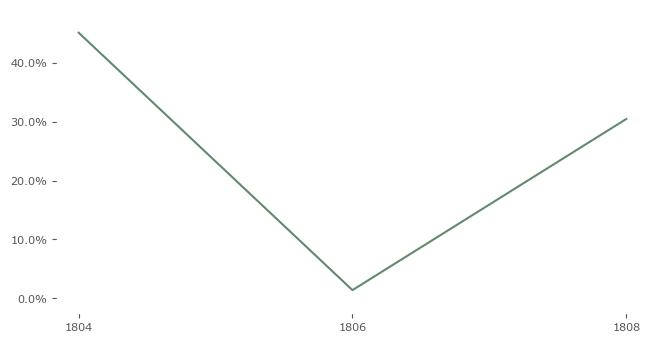

[{"x": "1804", "y": 44.9999}, {"x": "1806", "y": 1.7002}, {"x": "1808", "y": 30.4951}]


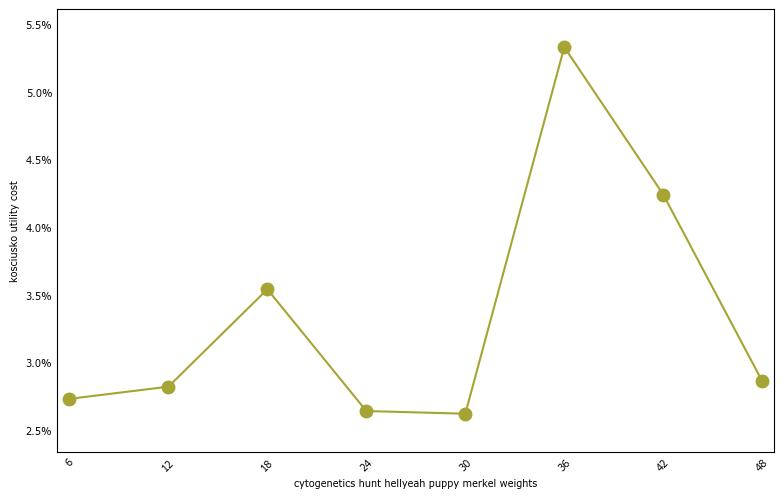

[{"x": "6", "y": 2.7469}, {"x": "12", "y": 2.8289}, {"x": "18", "y": 3.5569}, {"x": "20", "y": 2.6569}, {"x": "25", "y": 2.6419}, {"x": "36", "y": 5.0329}, {"x": "32", "y": 4.2479}, {"x": "38", "y": 2.8774}]


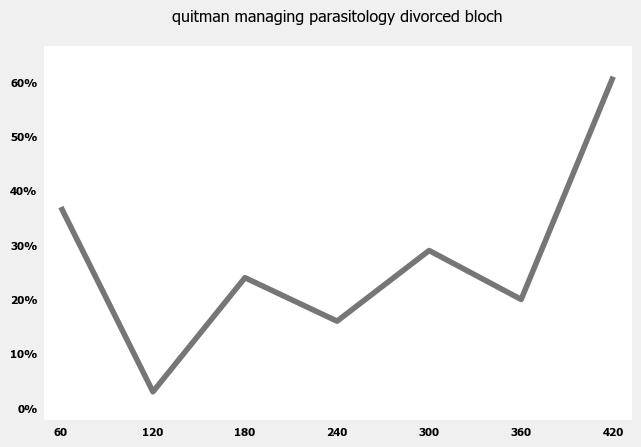

[{"x": "60", "y": 36.6322}, {"x": "120", "y": 3.5224}, {"x": "180", "y": 23.9224}, {"x": "240", "y": 16.5324}, {"x": "300", "y": 28.9054}, {"x": "360", "y": 21.0254}, {"x": "420", "y": 60.5054}]


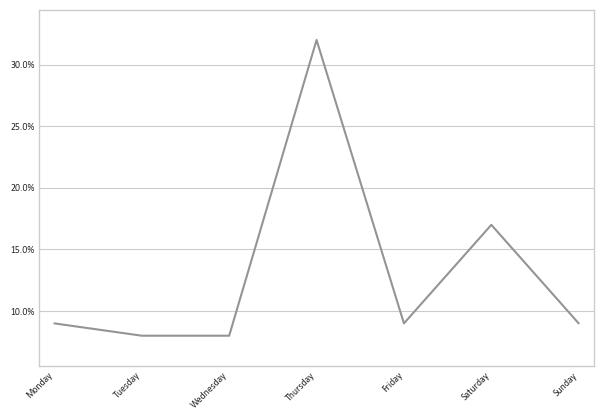

[{"x": "Monday", "y": 9.0009}, {"x": "Tuesday", "y": 8.2009}, {"x": "Wednesday", "y": 8.2009}, {"x": "Thursday", "y": 30.0099}, {"x": "Friday", "y": 9.0009}, {"x": "Saturday", "y": 16.7009}, {"x": "Sunday", "y": 9.0009}]


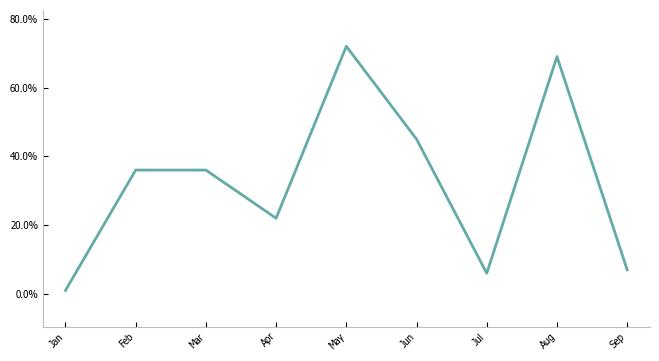

[{"x": "Jan", "y": 0.0099}, {"x": "Feb", "y": 3.6049}, {"x": "Mar", "y": 3.6049}, {"x": "Apr", "y": 22.0099}, {"x": "May", "y": 71.7099}, {"x": "Jan", "y": 44.7099}, {"x": "Jul", "y": 0.7019}, {"x": "Aug", "y": 67.0099}, {"x": "Sep", "y": 0.7019}]


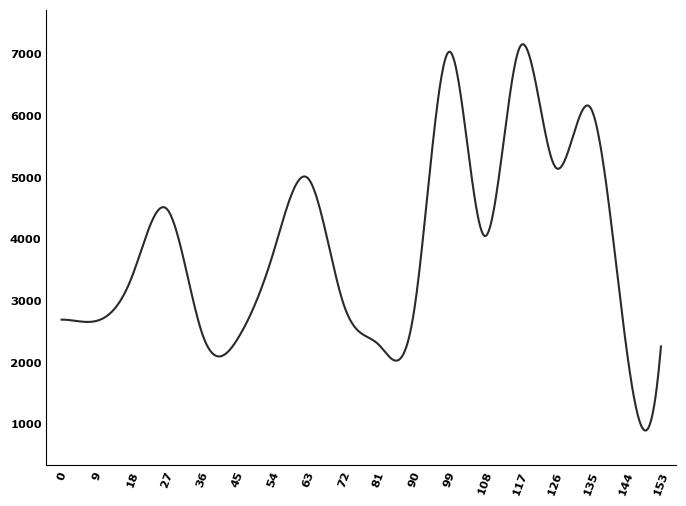

[{"x": "0", "y": 2700.0}, {"x": "8", "y": 2650.0}, {"x": "19", "y": 3400.0}, {"x": "27", "y": 4470.0}, {"x": "36", "y": 2450.0}, {"x": "45", "y": 2350.0}, {"x": "54", "y": 3800.0}, {"x": "66", "y": 5000.0}, {"x": "72", "y": 2800.0}, {"x": "81", "y": 2200.0}, {"x": "90", "y": 3200.0}, {"x": "99", "y": 6800.0}, {"x": "100", "y": 4100.0}, {"x": "1017", "y": 7100.0}, {"x": "106", "y": 5200.0}, {"x": "195", "y": 6100.0}, {"x": "1944", "y": 3200.0}, {"x": "1953", "y": 1100.0}]


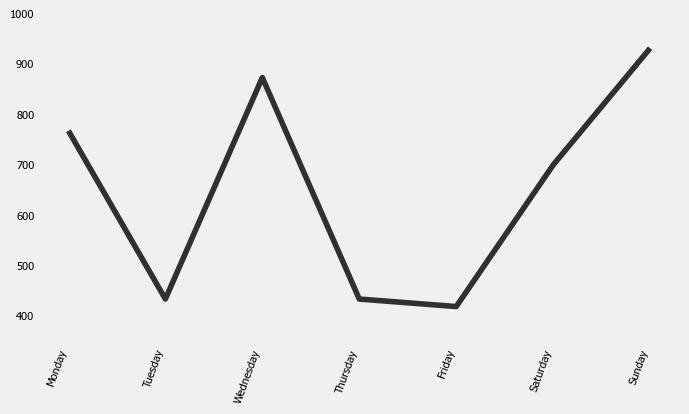

[{"x": "Monday", "y": 765.1229}, {"x": "Tuesday", "y": 445.1229}, {"x": "Wednesday", "y": 865.1229}, {"x": "Thursday", "y": 445.1229}, {"x": "Friday", "y": 425.1229}, {"x": "Saturday", "y": 675.1229}, {"x": "Sunday", "y": 929.1229}]


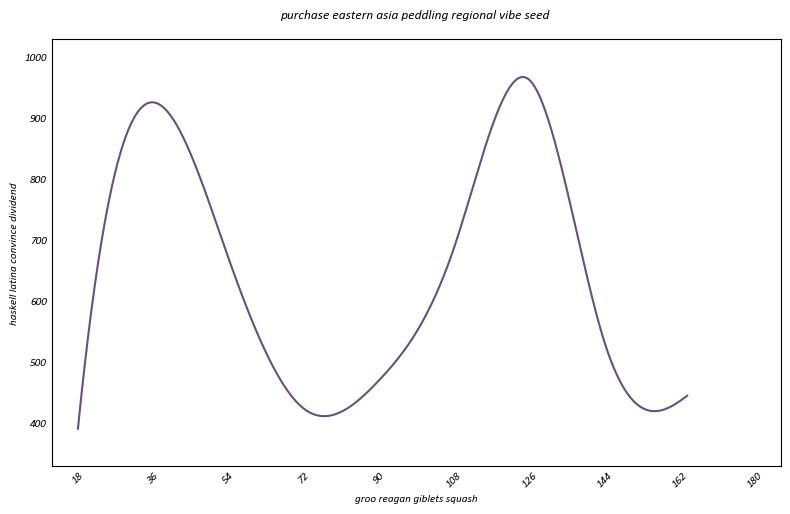

[{"x": "19.0", "y": 436.0}, {"x": "20.0", "y": 926.0}, {"x": "21.0", "y": 675.0}, {"x": "22.0", "y": 425.0}, {"x": "23.0", "y": 475.0}, {"x": "24.0", "y": 695.0}, {"x": "25.0", "y": 960.0}, {"x": "26.0", "y": 960.0}, {"x": "27.0", "y": 520.0}, {"x": "28.0", "y": 690.0}, {"x": "29.0", "y": 960.0}]


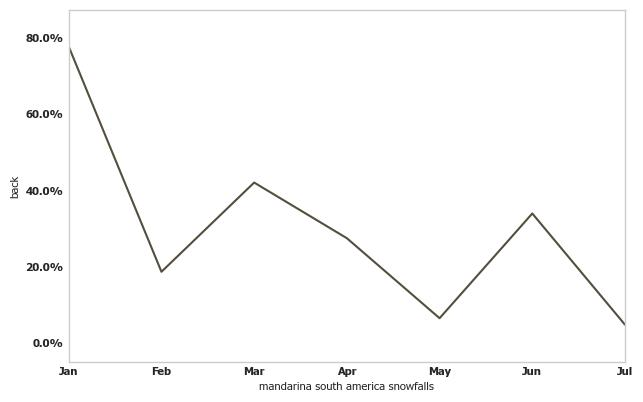

[{"x": "Jan", "y": 76.6322}, {"x": "Feb", "y": 19.6929}, {"x": "Mar", "y": 42.0129}, {"x": "Apr", "y": 26.6829}, {"x": "May", "y": 6.6029}, {"x": "Jun", "y": 33.7129}, {"x": "Jul", "y": 5.0099}]


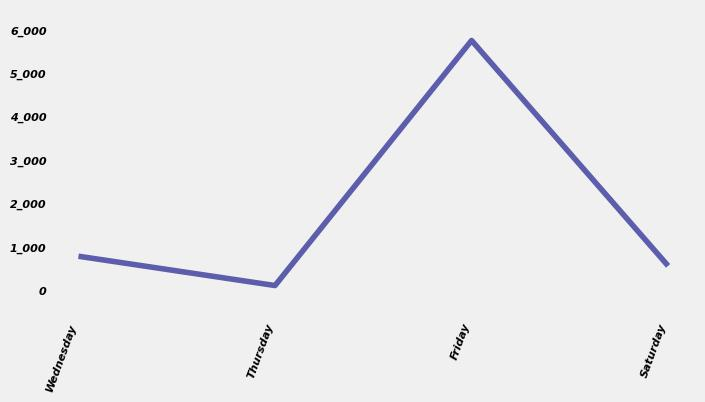

[{"x": "Wednesday", "y": 860.0}, {"x": "Thursday", "y": 150.0}, {"x": "Thursday", "y": 200.0}, {"x": "Thursday", "y": 1000.0}, {"x": "Saturday", "y": 600.0}]


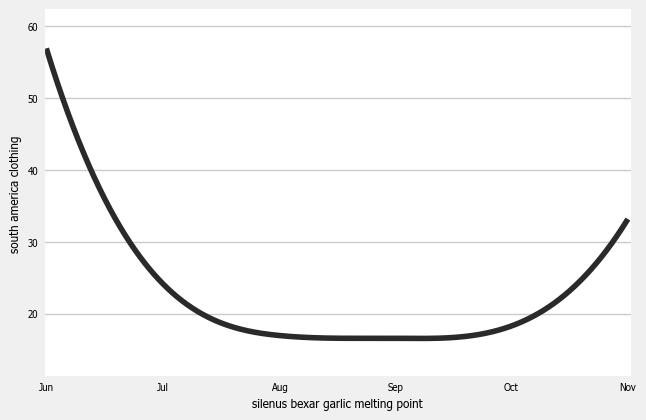

[{"x": "Jun", "y": 56.8222}, {"x": "Jul", "y": 23.5922}, {"x": "Aug", "y": 17.1222}, {"x": "Sep", "y": 16.9592}, {"x": "Oct", "y": 18.2222}, {"x": "Nov", "y": 33.1222}]


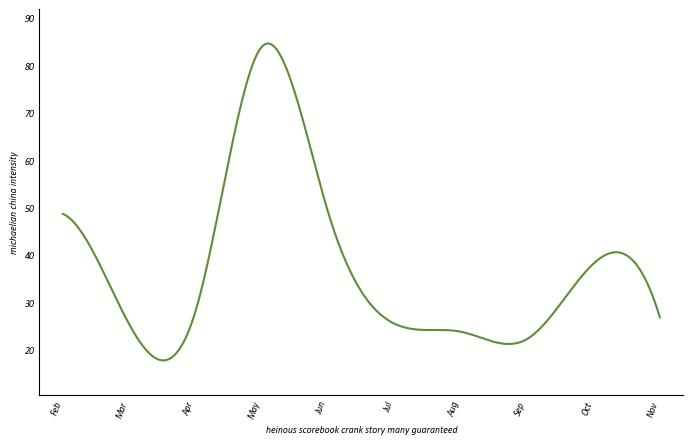

[{"x": "FED", "y": 49.3252}, {"x": "MAE", "y": 28.8254}, {"x": "MAE", "y": 24.1255}, {"x": "MAE", "y": 84.6254}, {"x": "MAE", "y": 55.1255}, {"x": "MAE", "y": 26.5254}, {"x": "MAE", "y": 24.6254}, {"x": "SGP", "y": 22.3254}, {"x": "SEK", "y": 36.5254}, {"x": "SEK", "y": 33.5254}]


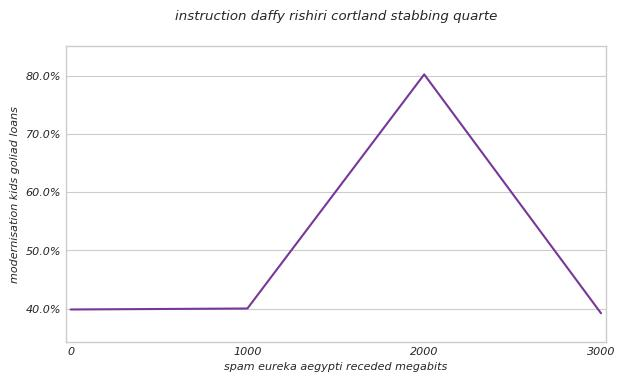

[{"x": "1000", "y": 40.0}, {"x": "2000", "y": 80.0}, {"x": "3000", "y": 39.0}]


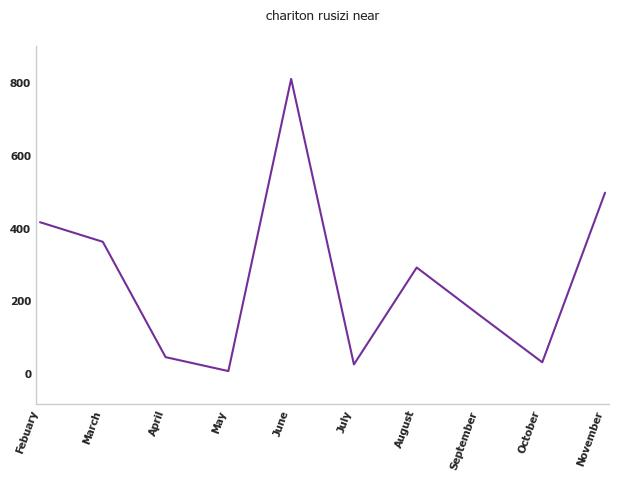

[{"x": "February", "y": 421.7132}, {"x": "March", "y": 370.0422}, {"x": "April", "y": 82.2129}, {"x": "May", "y": 11.2822}, {"x": "June", "y": 797.0721}, {"x": "May", "y": 32.1221}, {"x": "August", "y": 284.1221}, {"x": "September", "y": 174.5591}, {"x": "October", "y": 35.1221}, {"x": "November", "y": 471.7271}]


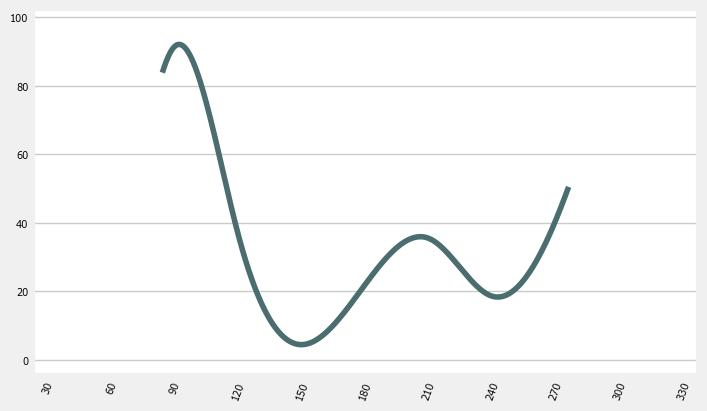

[{"x": "50", "y": 35.5322}, {"x": "60", "y": 35.5322}, {"x": "80", "y": 92.4222}, {"x": "120", "y": 35.5322}, {"x": "150", "y": 5.1222}, {"x": "180", "y": 23.1222}, {"x": "110", "y": 36.1222}, {"x": "40", "y": 18.9199}, {"x": "270", "y": 40.9199}, {"x": "300", "y": 35.5322}, {"x": "320", "y": 35.5322}]


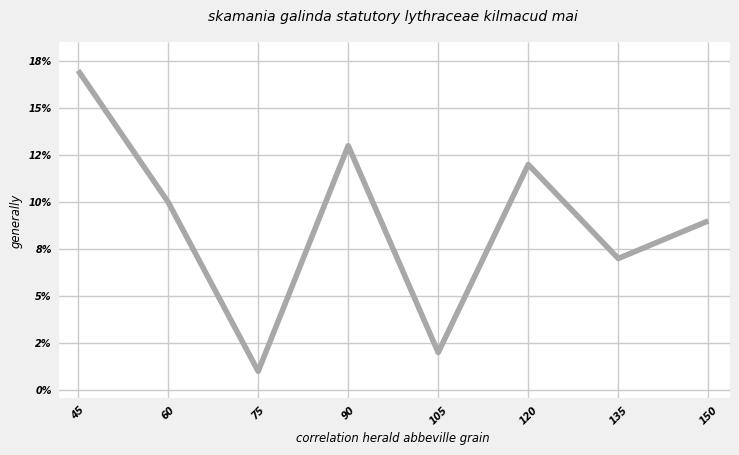

[{"x": "45", "y": 17.5852}, {"x": "80", "y": 10.0821}, {"x": "75", "y": 1.0221}, {"x": "90", "y": 12.2555}, {"x": "105", "y": 1.9221}, {"x": "120", "y": 11.6021}, {"x": "125", "y": 7.6821}, {"x": "150", "y": 9.2081}]


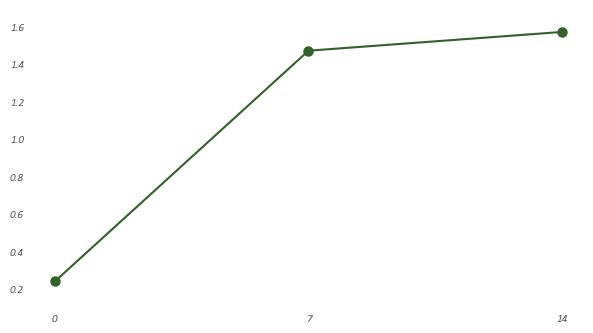

[{"x": "0", "y": 0.2539}, {"x": "7", "y": 1.4801}, {"x": "14", "y": 1.5801}]


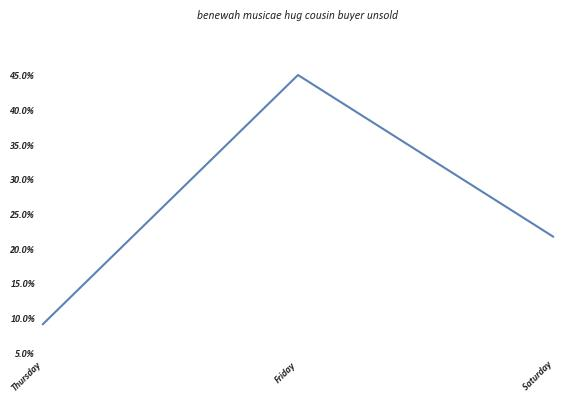

[{"x": "Thursday", "y": 9.9672}, {"x": "Friday", "y": 45.0252}, {"x": "Saturday", "y": 22.0971}]


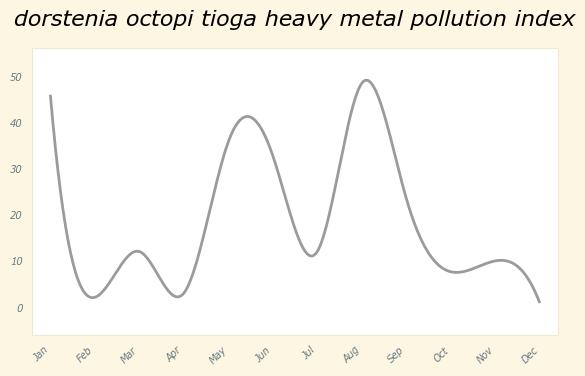

[{"x": "Jan", "y": 46.2222}, {"x": "Feb", "y": 2.6053}, {"x": "Mar", "y": 12.0129}, {"x": "Apr", "y": 2.9555}, {"x": "May", "y": 31.9255}, {"x": "Jun", "y": 38.2755}, {"x": "Jul", "y": 11.7255}, {"x": "Aug", "y": 46.5755}, {"x": "Sep", "y": 31.9255}, {"x": "Oct", "y": 8.0199}, {"x": "Nov", "y": 10.0199}, {"x": "Dec", "y": 4.0199}]


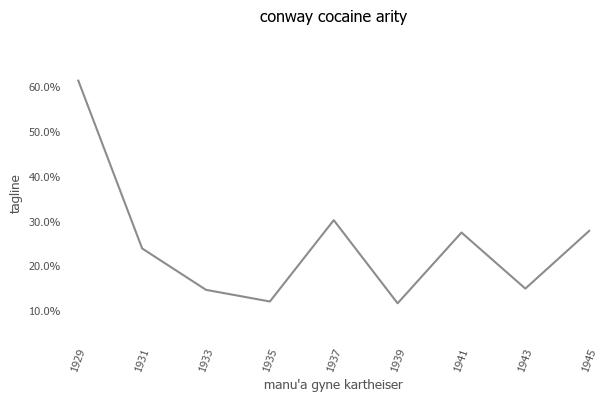

[{"x": "1929", "y": 60.0222}, {"x": "1931", "y": 24.0222}, {"x": "1933", "y": 14.8622}, {"x": "1935", "y": 12.5022}, {"x": "1937", "y": 30.2022}, {"x": "1939", "y": 12.0222}, {"x": "1941", "y": 27.3022}, {"x": "1943", "y": 15.6022}, {"x": "1945", "y": 28.0022}]


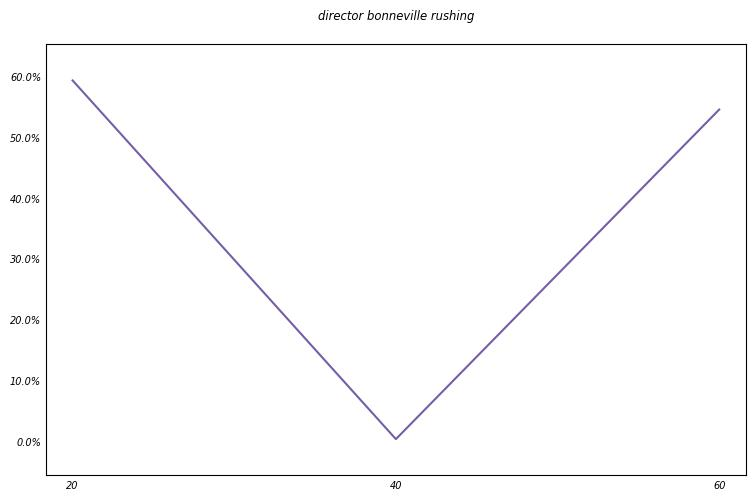

[{"x": "20", "y": 59.7832}, {"x": "40", "y": 0.9921}, {"x": "60", "y": 54.8871}]


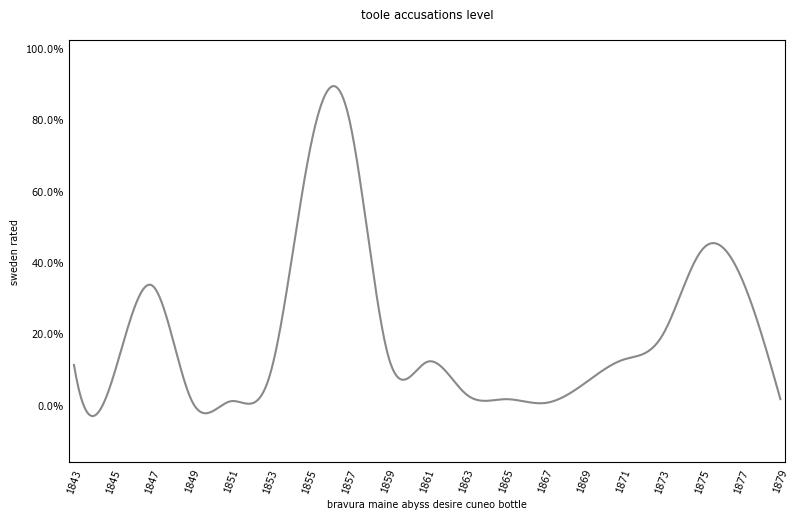

[{"x": "1960", "y": 1.1282}, {"x": "1961", "y": 3.3822}, {"x": "1962", "y": 0.0882}, {"x": "1963", "y": 1.1282}, {"x": "1964", "y": 1.1282}, {"x": "1965", "y": 1.1282}, {"x": "1966", "y": 7.0182}, {"x": "1967", "y": 8.0182}, {"x": "1968", "y": 1.1282}, {"x": "1969", "y": 0.0862}, {"x": "1970", "y": 4.0182}, {"x": "1977", "y": 3.5912}, {"x": "1978", "y": 1.1185}, {"x": "1979", "y": 0.0862}]


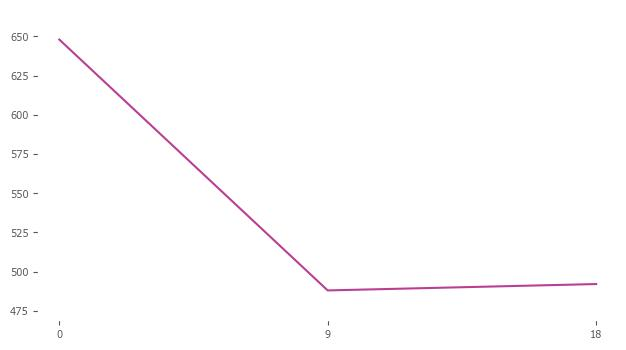

[{"x": "0", "y": 648.5121}, {"x": "9", "y": 489.0049}, {"x": "18", "y": 492.9121}]


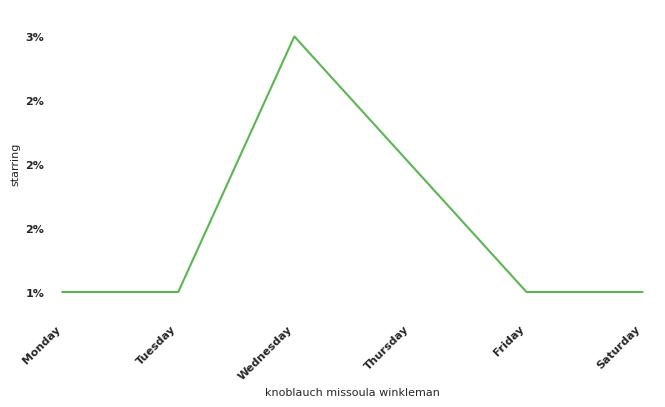

[{"x": "Monday", "y": 1.0073}, {"x": "Tuesday", "y": 1.0073}, {"x": "Wednesday", "y": 2.9899}, {"x": "Thursday", "y": 2.0799}, {"x": "Friday", "y": 1.0073}, {"x": "Saturday", "y": 1.0073}]


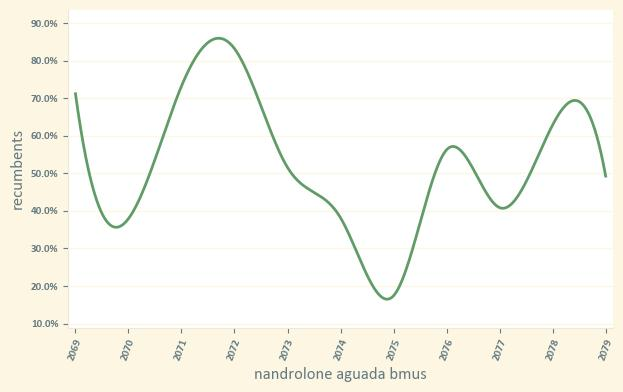

[{"x": "2000", "y": 37.9999}, {"x": "2001", "y": 73.8299}, {"x": "2002", "y": 84.0499}, {"x": "2003", "y": 51.0299}, {"x": "2004", "y": 37.9199}, {"x": "2005", "y": 18.2889}, {"x": "2006", "y": 57.0199}, {"x": "2007", "y": 40.9199}, {"x": "2008", "y": 64.0199}, {"x": "2009", "y": 50.0199}]


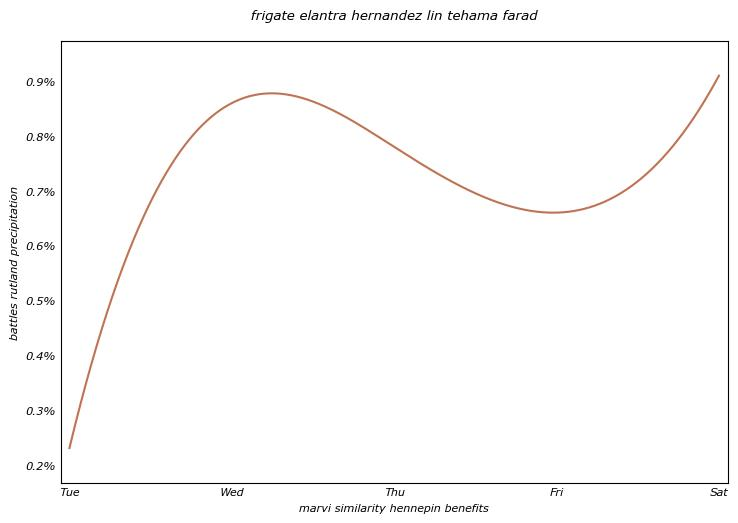

[{"x": "Tue", "y": 0.298}, {"x": "Wed", "y": 0.8664}, {"x": "Marvi similarity", "y": 0.8821}, {"x": "Thu", "y": 0.7781}, {"x": "Fri", "y": 0.6631}, {"x": "Sat", "y": 0.9178}]


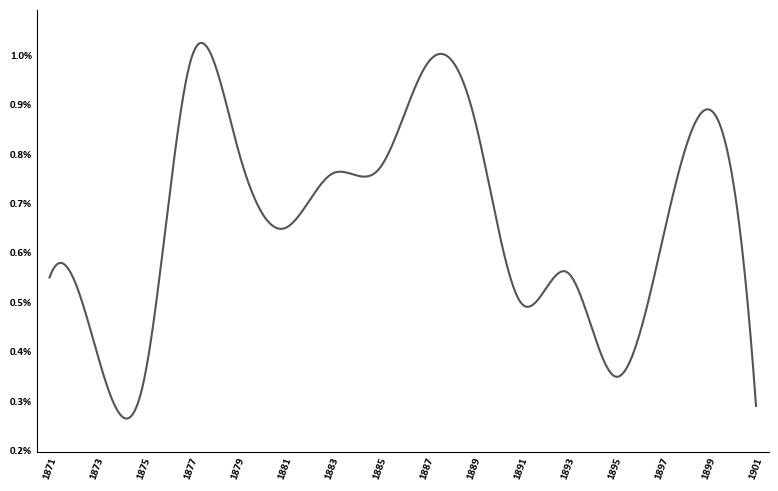

[{"x": "2001", "y": 0.5642}, {"x": "2002", "y": 0.4422}, {"x": "2003", "y": 0.4392}, {"x": "2004", "y": 0.7632}, {"x": "2005", "y": 0.7661}, {"x": "2006", "y": 0.7601}, {"x": "2007", "y": 0.6621}, {"x": "2008", "y": 0.8621}, {"x": "2009", "y": 0.8621}, {"x": "2010", "y": 0.4391}]


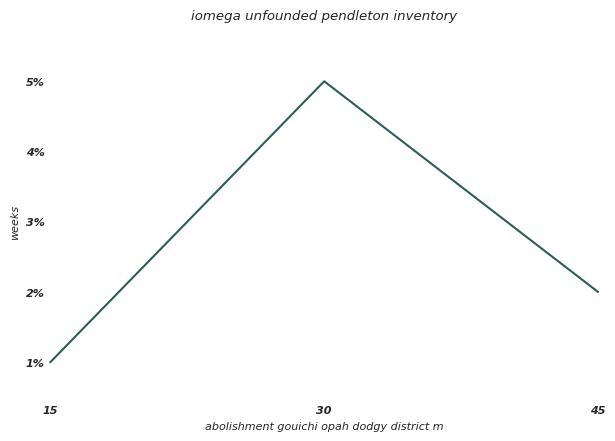

[{"x": "15", "y": 1.9959}, {"x": "20", "y": 2.9959}, {"x": "45", "y": 2.0059}]


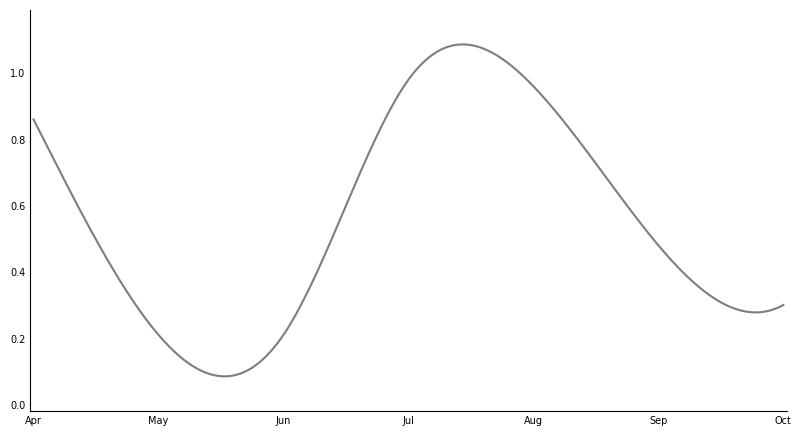

[{"x": "Apr", "y": 0.8652}, {"x": "May", "y": 0.2392}, {"x": "Jun", "y": 0.2592}, {"x": "Jul", "y": 0.9952}, {"x": "Aug", "y": 0.9552}, {"x": "Sep", "y": 0.4792}, {"x": "Oct", "y": 0.3011}]


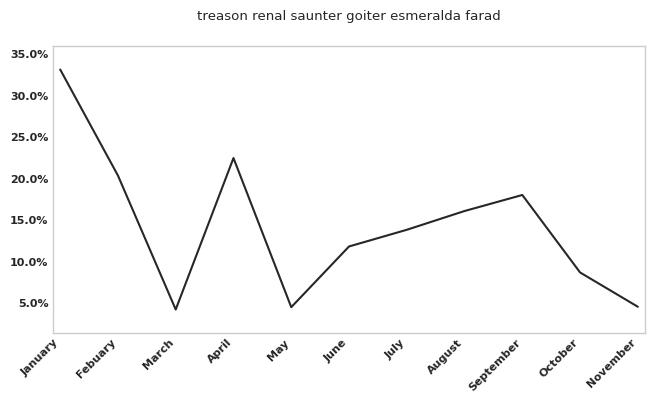

[{"x": "January", "y": 34.1252}, {"x": "February", "y": 22.0059}, {"x": "March", "y": 5.0059}, {"x": "April", "y": 22.0059}, {"x": "May", "y": 5.0059}, {"x": "June", "y": 11.6859}, {"x": "July", "y": 13.9159}, {"x": "August", "y": 16.0559}, {"x": "September", "y": 18.0159}, {"x": "October", "y": 10.5159}, {"x": "November", "y": 5.0059}]


In [6]:
print("start loop:")
for i in range(84360, 84401):
    image_path = f"/kaggle/input/benetech-extra-generated-data/graphs_l/{i}.jpg"
    try:
        image = Image.open(image_path)
        display(image)
        inputs = processor(images=image, text="Generate data series:", return_tensors="pt")
        
        # Move inputs to GPU
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        predictions = model.generate(**inputs, max_new_tokens=2048)
        print(processor.decode(predictions[0], skip_special_tokens=True))
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

In [7]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pandas as pd
import json
import os
import torch

# Set CUDA environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Load processor and model
model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/working/deplot_line_finetuned")
processor = AutoProcessor.from_pretrained("/kaggle/working/deplot_line_finetuned")

class CSVChartDataset(Dataset):
    def __init__(self, images_dir, annotations_csv, processor):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(annotations_csv)
        self.processor = processor

    def __len__(self):
        return min(500, len(self.annotations))  # Use only 2000 images for fine-tuning

    def __getitem__(self, idx):
        idx = idx + 210000
        row = self.annotations.iloc[idx]
        image_path = os.path.join(self.images_dir, os.path.basename(row["file_name"]))
        data_series = row["text"]

        # Convert the data-series to JSON-like format
        data_series_json = []
        for pair in data_series.split("<0x0A>"):
            if "|" in pair:
                x, y = pair.split("|")
                data_series_json.append({"x": x.strip(), "y": round(float(y.strip()), 4)})

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image and data series
        inputs = self.processor(images=image, text="Generate data series:", return_tensors="pt")

        return {
            "flattened_patches": inputs["flattened_patches"].squeeze(),
            "labels": torch.tensor(
                self.processor.tokenizer(
                    json.dumps(data_series_json, ensure_ascii=False),
                    padding="max_length",
                    max_length=512,
                    truncation=True
                ).input_ids
            )
        }

# Custom data collator
def custom_data_collator(features):
    flattened_patches = torch.stack([feature["flattened_patches"] for feature in features])
    labels = torch.nn.utils.rnn.pad_sequence([feature["labels"] for feature in features], batch_first=True, padding_value=-100)
    return {"flattened_patches": flattened_patches, "labels": labels}

# Paths to your data directories
images_dir = "/kaggle/input/benetech-extra-generated-data/graphs_l"
annotations_csv = "/kaggle/input/benetech-extra-generated-data/metadata.csv"

# Prepare dataset
dataset = CSVChartDataset(images_dir, annotations_csv, processor)

# Split dataset into training and evaluation
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/deplot_finetuned_v2",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,
    logging_dir="/kaggle/working/logs_v2",
    logging_steps=100,
    push_to_hub=False,
    dataloader_num_workers=2,
    ddp_find_unused_parameters=False,
    report_to=["none"],
    gradient_accumulation_steps=2,
    no_cuda=False,
    load_best_model_at_end=True
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.tokenizer,
    data_collator=custom_data_collator
)

# Train model
trainer.train()

# Save the model
model.save_pretrained("/kaggle/working/deplot_line_finetuned_v2")
processor.save_pretrained("/kaggle/working/deplot_line_finetuned_v2")

<ipython-input-7-a047ea846cc9>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

[]

In [8]:
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
import os
import torch
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/working/deplot_line_finetuned_v2").to(device)
processor = AutoProcessor.from_pretrained("/kaggle/working/deplot_line_finetuned_v2")

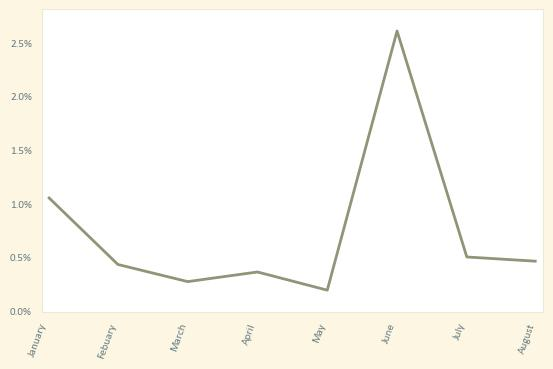

[{"x": "January", "y": 1.0}, {"x": "Febuary", "y": 0.5}, {"x": "March", "y": 0.3}, {"x": "April", "y": 0.3}, {"x": "May", "y": 0.2}, {"x": "June", "y": 2.0}, {"x": "July", "y": 0.5}, {"x": "August", "y": 0.5}]


In [9]:
# Load an example image for prediction
image_path = "/kaggle/input/benetech-extra-generated-data/graphs_l/84359.jpg"
image = Image.open(image_path)
display(image)

inputs = processor(images=image, text="Generate data series:", return_tensors="pt")

# Move inputs to GPU
inputs = {key: value.to(device) for key, value in inputs.items()}

predictions = model.generate(**inputs, max_new_tokens=2048)
print(processor.decode(predictions[0], skip_special_tokens=True))

start loop:


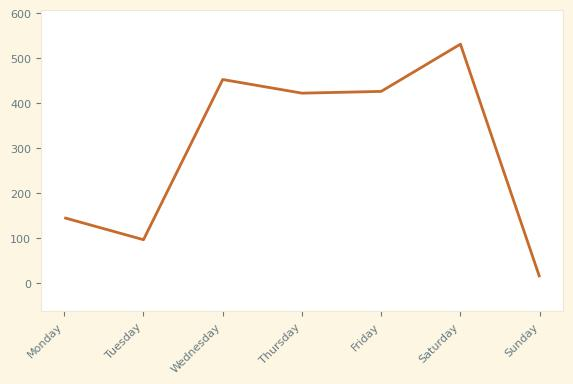

[{"x": "Monday", "y": 150.0}, {"x": "Tuesday", "y": 100.0}, {"x": "Wednesday", "y": 450.0}, {"x": "Thursday", "y": 420.0}, {"x": "Friday", "y": 430.0}, {"x": "Saturday", "y": 530.0}, {"x": "Sunday", "y": 0.0}]


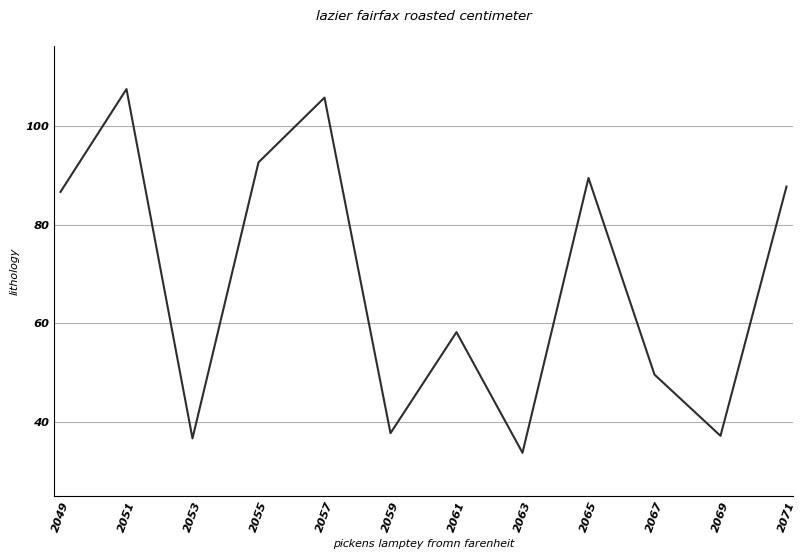

[{"x": "2009", "y": 80.0}, {"x": "2011", "y": 100.0}, {"x": "2013", "y": 40.0}, {"x": "2015", "y": 90.0}, {"x": "2017", "y": 100.0}, {"x": "2018", "y": 40.0}, {"x": "2019", "y": 60.0}, {"x": "2021", "y": 80.0}, {"x": "2024", "y": 90.0}, {"x": "2025", "y": 90.0}, {"x": "2026", "y": 90.0}, {"x": "2027", "y": 50.0}, {"x": "2028", "y": 40.0}, {"x": "2029", "y": 80.0}, {"x": "2031", "y": 90.0}]


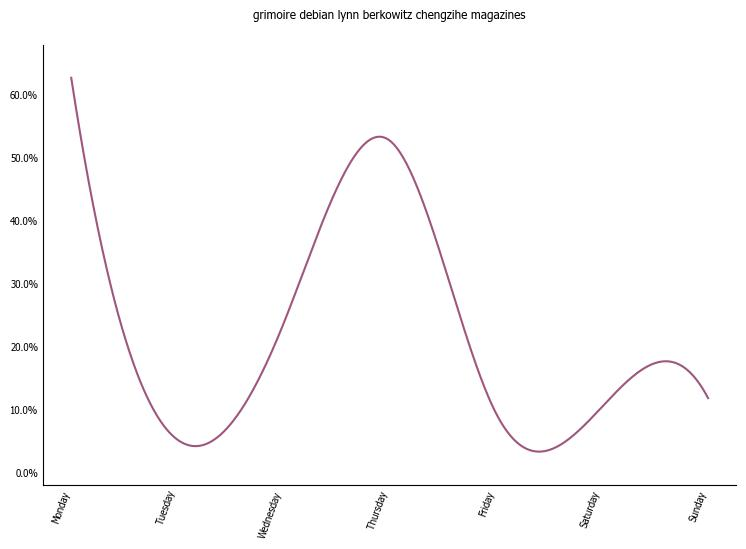

[{"x": "Monday", "y": 60.0}, {"x": "Tuesday", "y": 10.0}, {"x": "Wednesday", "y": 20.0}, {"x": "Thursday", "y": 50.0}, {"x": "Friday", "y": 10.0}, {"x": "Saturday", "y": 10.0}, {"x": "Sunday", "y": 10.0}]


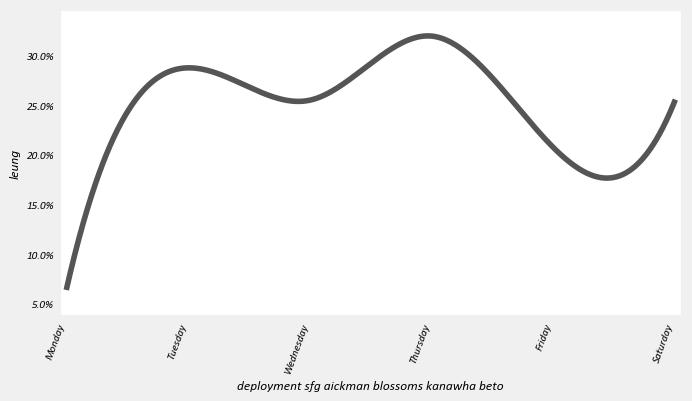

[{"x": "Monday", "y": 10.0}, {"x": "Tuesday", "y": 30.0}, {"x": "Wednesday", "y": 20.0}, {"x": "Thursday", "y": 30.0}, {"x": "Friday", "y": 20.0}, {"x": "Saturday", "y": 20.0}]


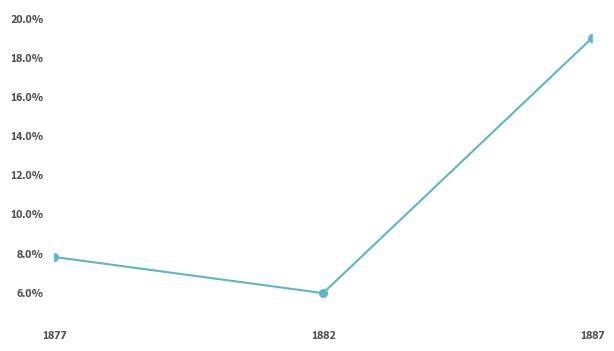

[{"x": "1877", "y": 8.0}, {"x": "1882", "y": 6.0}, {"x": "1887", "y": 19.0}]


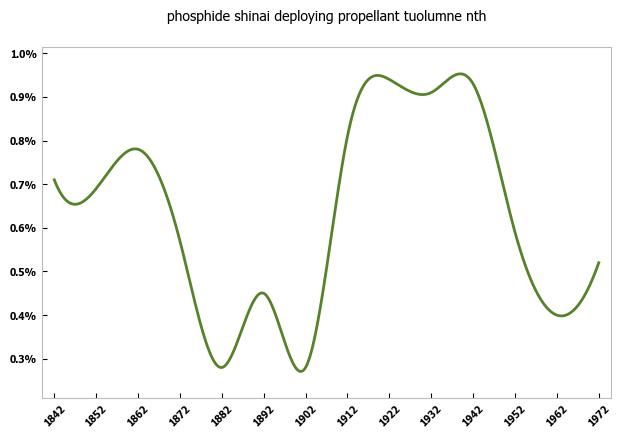

[{"x": "1842", "y": 0.7}, {"x": "1852", "y": 0.7}, {"x": "1862", "y": 0.8}, {"x": "1872", "y": 0.5}, {"x": "1882", "y": 0.3}, {"x": "1892", "y": 0.5}, {"x": "1902", "y": 0.3}, {"x": "1912", "y": 0.8}, {"x": "1922", "y": 0.9}, {"x": "1932", "y": 0.9}, {"x": "1942", "y": 0.9}, {"x": "1952", "y": 0.6}, {"x": "1962", "y": 0.4}, {"x": "1972", "y": 0.5}]


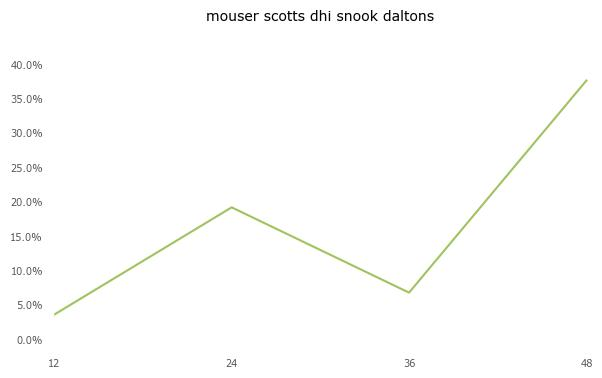

[{"x": "12", "y": 4.0}, {"x": "24", "y": 20.0}, {"x": "36", "y": 10.0}, {"x": "48", "y": 40.0}]


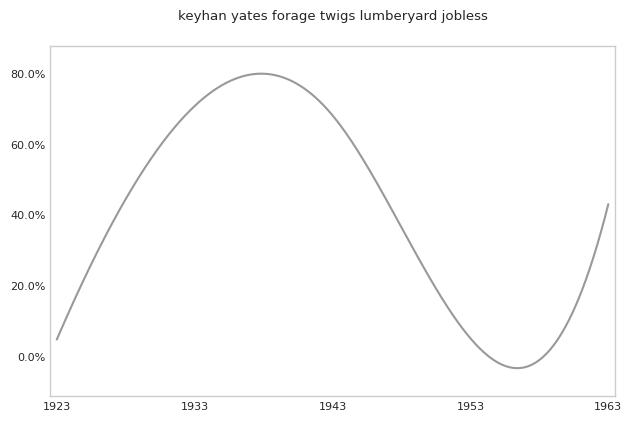

[{"x": "1923", "y": 0.0}, {"x": "1933", "y": 70.0}, {"x": "1943", "y": 70.0}, {"x": "1953", "y": 0.0}, {"x": "1963", "y": 40.0}]


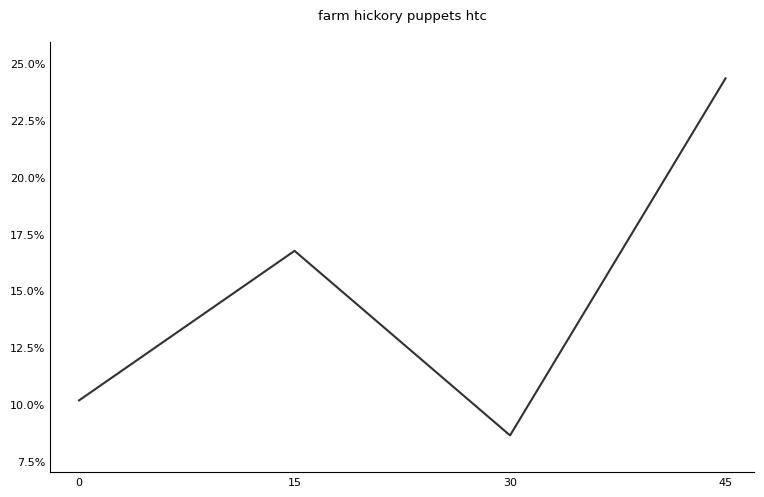

[{"x": "0", "y": 10.0}, {"x": "15", "y": 16.0}, {"x": "30", "y": 9.0}, {"x": "45", "y": 24.0}]


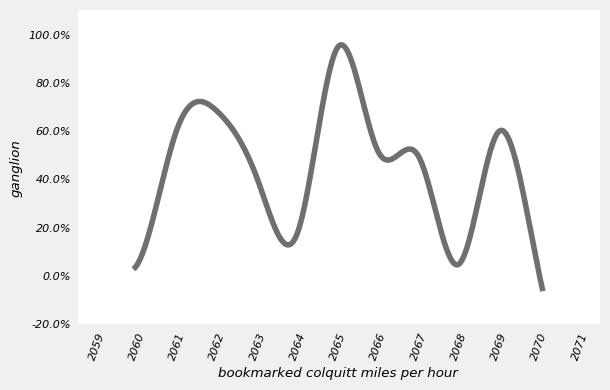

[{"x": "2060", "y": 10.0}, {"x": "2061", "y": 70.0}, {"x": "2062", "y": 70.0}, {"x": "2063", "y": 40.0}, {"x": "2064", "y": 10.0}, {"x": "2065", "y": 100.0}, {"x": "2066", "y": 50.0}, {"x": "2067", "y": 50.0}, {"x": "2068", "y": 10.0}, {"x": "2069", "y": 60.0}, {"x": "2070", "y": 10.0}]


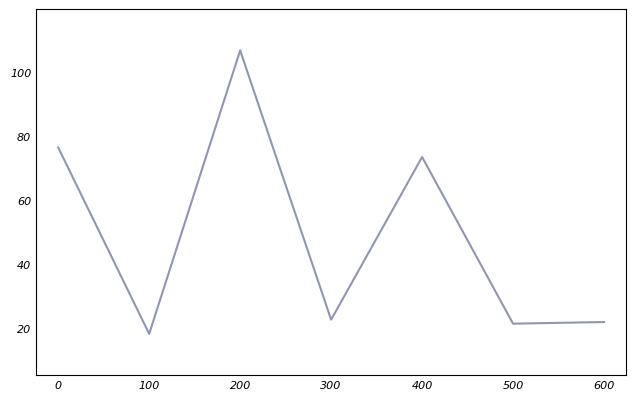

[{"x": "0", "y": 80.0}, {"x": "100", "y": 20.0}, {"x": "200", "y": 110.0}, {"x": "300", "y": 20.0}, {"x": "400", "y": 70.0}, {"x": "500", "y": 20.0}, {"x": "600", "y": 20.0}]


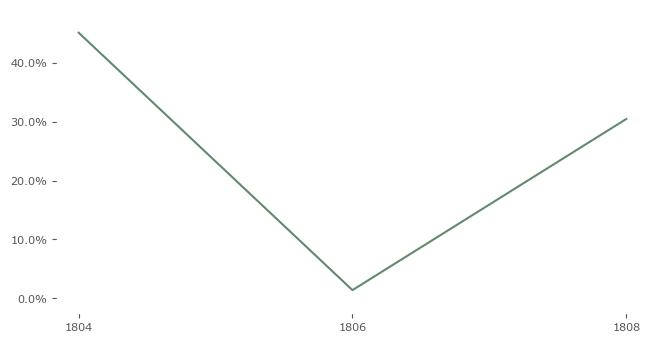

[{"x": "1804", "y": 40.0}, {"x": "1806", "y": 0.0}, {"x": "1808", "y": 30.0}]


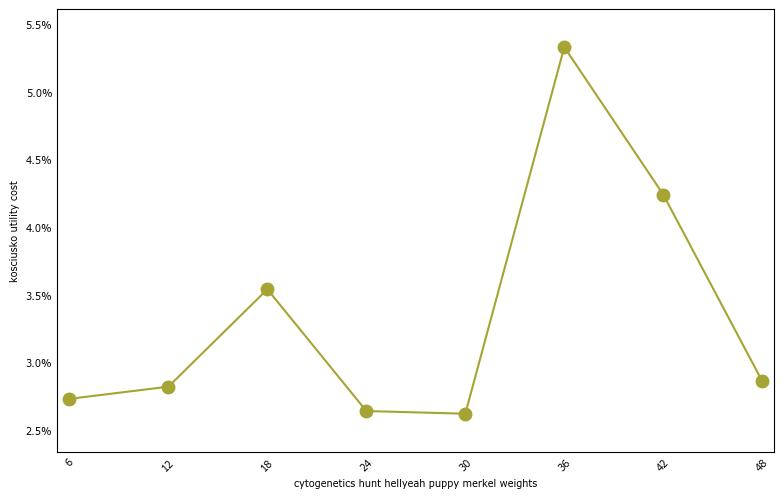

[{"x": "6", "y": 2.7}, {"x": "12", "y": 2.8}, {"x": "16", "y": 3.6}, {"x": "24", "y": 2.7}, {"x": "30", "y": 2.7}, {"x": "36", "y": 5.6}, {"x": "42", "y": 4.2}, {"x": "48", "y": 2.8}]


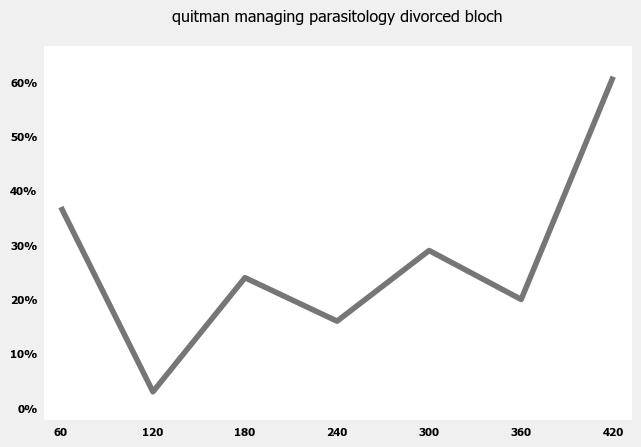

[{"x": "60", "y": 40.0}, {"x": "120", "y": 0.0}, {"x": "180", "y": 20.0}, {"x": "240", "y": 20.0}, {"x": "300", "y": 30.0}, {"x": "360", "y": 20.0}, {"x": "420", "y": 60.0}]


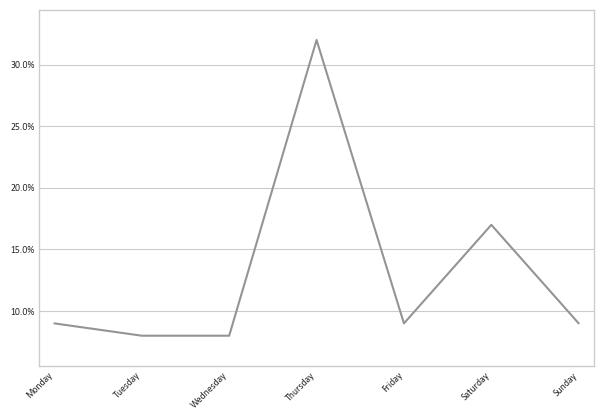

[{"x": "Monday", "y": 10.0}, {"x": "Tuesday", "y": 10.0}, {"x": "Wednesday", "y": 10.0}, {"x": "Thursday", "y": 30.0}, {"x": "Friday", "y": 10.0}, {"x": "Saturday", "y": 17.0}, {"x": "Sunday", "y": 10.0}]


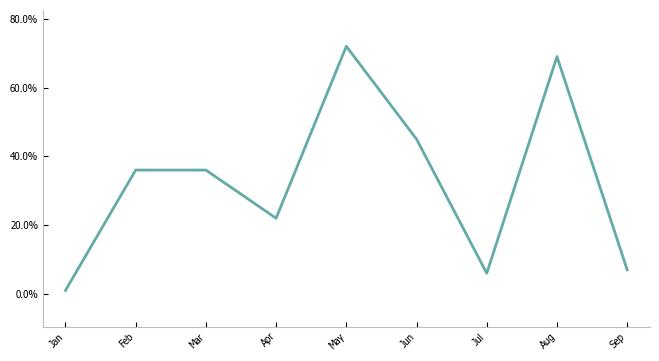

[{"x": "Jan", "y": 0.0}, {"x": "Feb", "y": 30.0}, {"x": "Mar", "y": 30.0}, {"x": "Apr", "y": 20.0}, {"x": "May", "y": 70.0}, {"x": "Jun", "y": 40.0}, {"x": "Jul", "y": 10.0}, {"x": "Aug", "y": 70.0}, {"x": "Sep", "y": 10.0}]


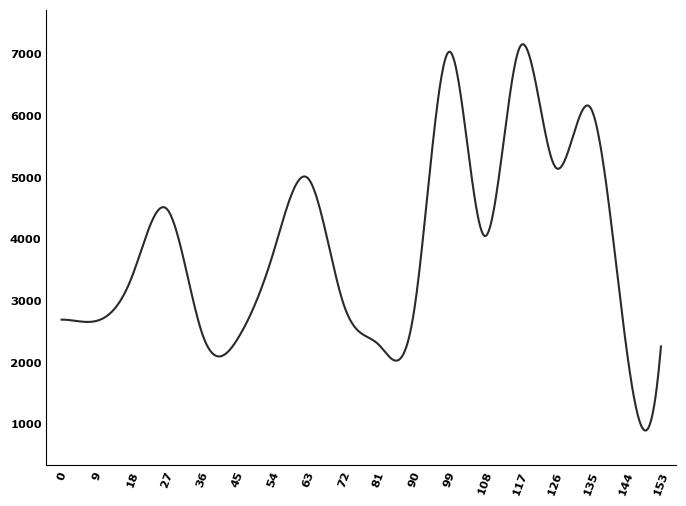

[{"x": "0", "y": 3000.0}, {"x": "9", "y": 3000.0}, {"x": "18", "y": 3000.0}, {"x": "27", "y": 4000.0}, {"x": "36", "y": 2000.0}, {"x": "45", "y": 2000.0}, {"x": "54", "y": 4000.0}, {"x": "63", "y": 5000.0}, {"x": "72", "y": 3000.0}, {"x": "81", "y": 2000.0}, {"x": "90", "y": 3000.0}, {"x": "99", "y": 7000.0}, {"x": "108", "y": 4000.0}, {"x": "117", "y": 7000.0}, {"x": "126", "y": 5000.0}, {"x": "135", "y": 6000.0}, {"x": "144", "y": 2000.0}, {"x": "153", "y": 2000.0}]


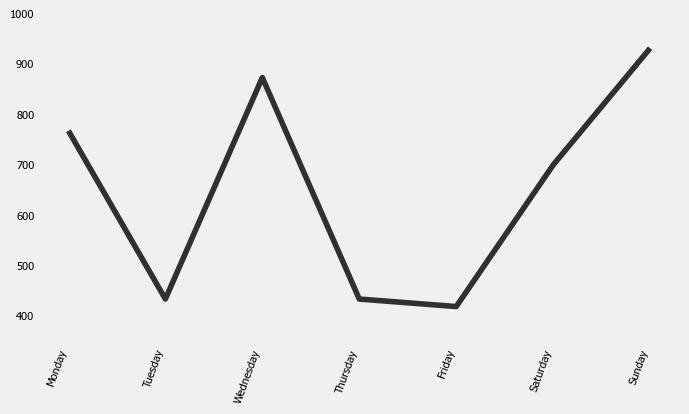

[{"x": "Monday", "y": 800.0}, {"x": "Tuesday", "y": 400.0}, {"x": "Wednesday", "y": 900.0}, {"x": "Thursday", "y": 400.0}, {"x": "Friday", "y": 400.0}, {"x": "Saturday", "y": 700.0}, {"x": "Sunday", "y": 900.0}]


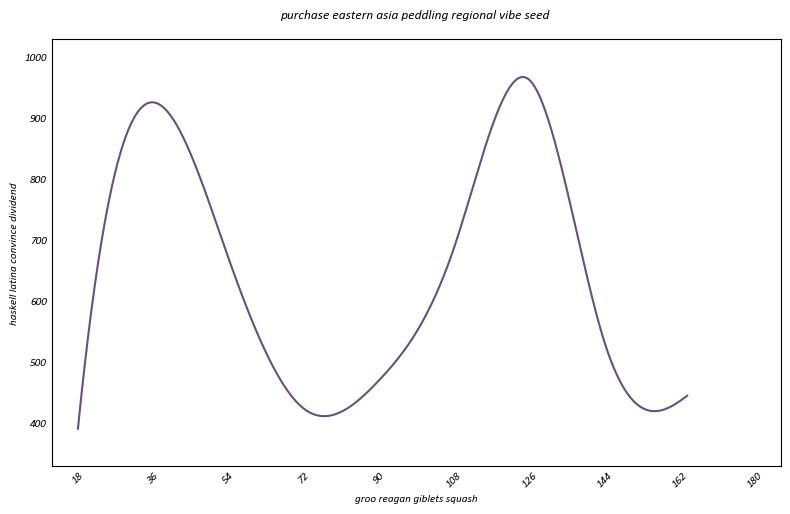

[{"x": "18", "y": 400.0}, {"x": "26", "y": 900.0}, {"x": "54", "y": 700.0}, {"x": "77", "y": 400.0}, {"x": "80", "y": 500.0}, {"x": "108", "y": 700.0}, {"x": "116", "y": 900.0}, {"x": "144", "y": 500.0}, {"x": "152", "y": 400.0}]


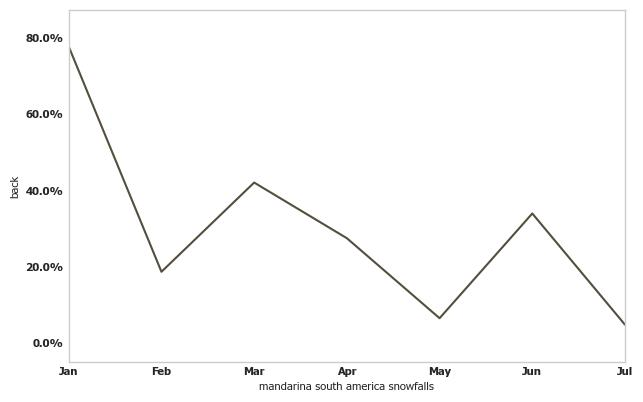

[{"x": "Jan", "y": 80.0}, {"x": "Feb", "y": 20.0}, {"x": "Mar", "y": 40.0}, {"x": "Apr", "y": 30.0}, {"x": "May", "y": 10.0}, {"x": "Jun", "y": 30.0}, {"x": "Jul", "y": 0.0}]


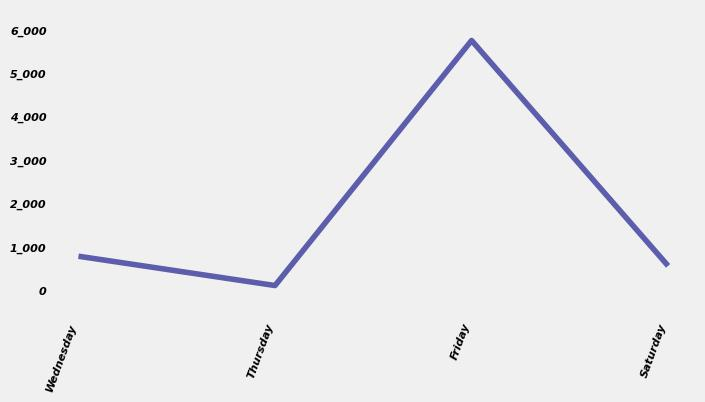

[{"x": "Wednesday", "y": 1000.0}, {"x": "Thursday", "y": 0.0}, {"x": "Friday", "y": 6000.0}, {"x": "Saturday", "y": 1000.0}]


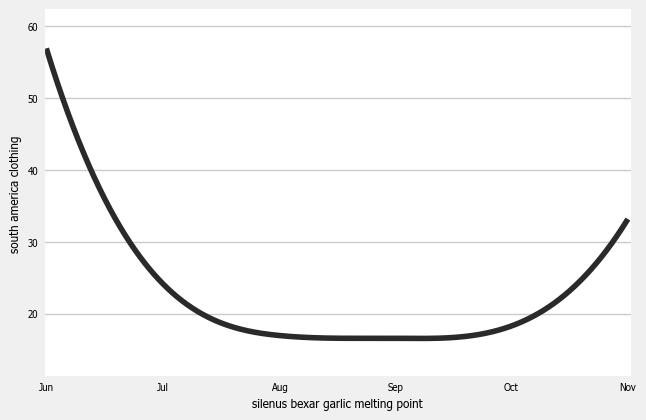

[{"x": "Jun", "y": 50.0}, {"x": "Jul", "y": 20.0}, {"x": "Aug", "y": 20.0}, {"x": "Sep", "y": 20.0}, {"x": "Oct", "y": 20.0}, {"x": "Nov", "y": 30.0}]


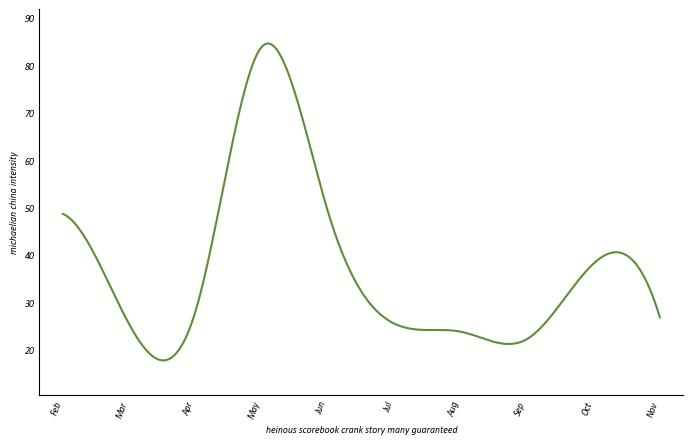

[{"x": "Feb", "y": 50.0}, {"x": "Mar", "y": 30.0}, {"x": "Apr", "y": 20.0}, {"x": "May", "y": 80.0}, {"x": "Jun", "y": 50.0}, {"x": "Jul", "y": 30.0}, {"x": "Aug", "y": 20.0}, {"x": "Sep", "y": 20.0}, {"x": "Oct", "y": 40.0}, {"x": "Nov", "y": 30.0}]


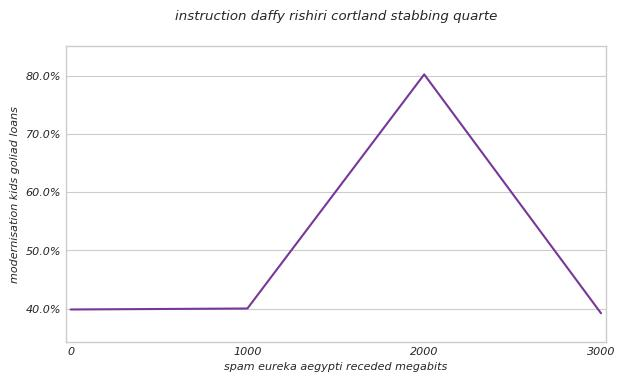

[{"x": "0", "y": 40.0}, {"x": "1000", "y": 40.0}, {"x": "2000", "y": 80.0}, {"x": "3000", "y": 40.0}]


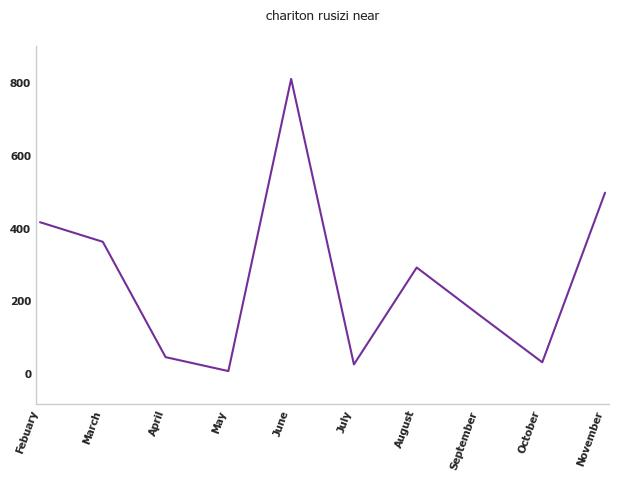

[{"x": "Febuary", "y": 400.0}, {"x": "March", "y": 400.0}, {"x": "April", "y": 100.0}, {"x": "May", "y": 0.0}, {"x": "June", "y": 800.0}, {"x": "July", "y": 0.0}, {"x": "August", "y": 300.0}, {"x": "September", "y": 200.0}, {"x": "October", "y": 0.0}, {"x": "November", "y": 500.0}]


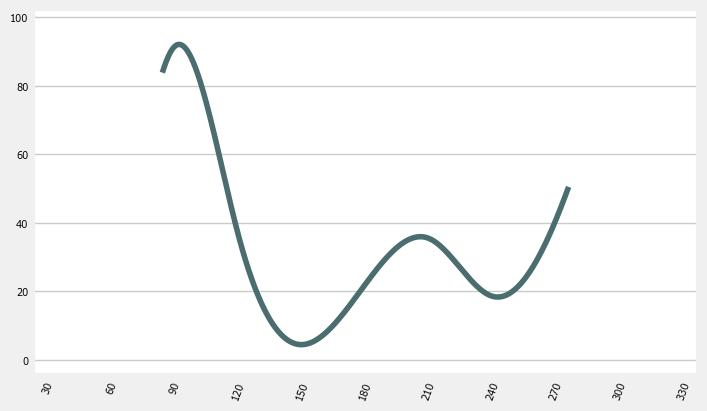

[{"x": "300", "y": 20.0}, {"x": "60", "y": 0.0}, {"x": "90", "y": 90.0}, {"x": "120", "y": 40.0}, {"x": "150", "y": 0.0}, {"x": "180", "y": 20.0}, {"x": "210", "y": 40.0}, {"x": "240", "y": 20.0}, {"x": "270", "y": 40.0}]


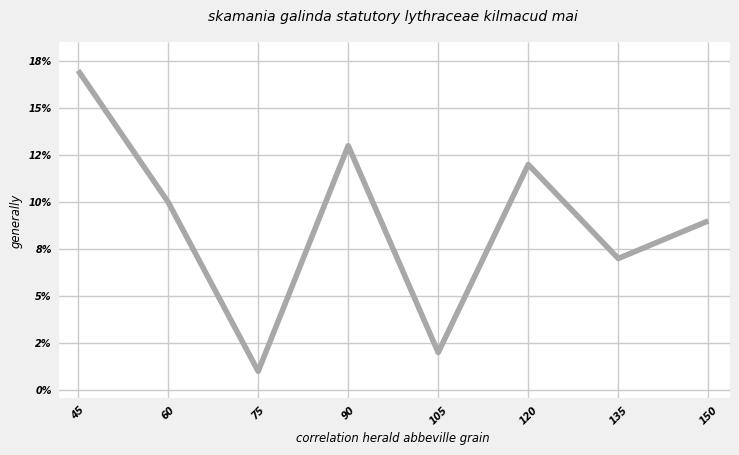

[{"x": "45", "y": 18.0}, {"x": "80", "y": 10.0}, {"x": "75", "y": 1.0}, {"x": "90", "y": 12.0}, {"x": "105", "y": 2.0}, {"x": "120", "y": 12.0}, {"x": "135", "y": 8.0}, {"x": "150", "y": 9.0}]


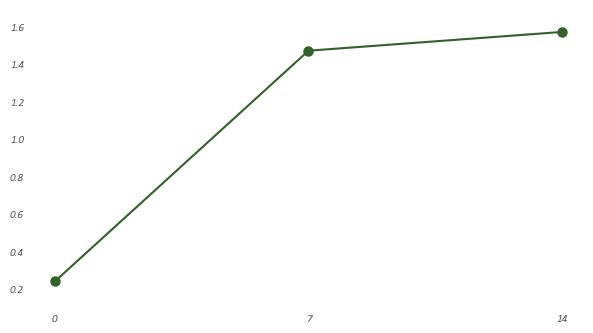

[{"x": "0", "y": 0.3}, {"x": "7", "y": 1.5}, {"x": "14", "y": 1.6}]


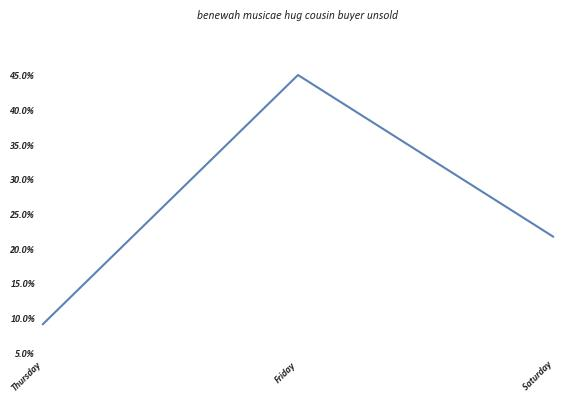

[{"x": "Thursday", "y": 10.0}, {"x": "Friday", "y": 40.0}, {"x": "Saturday", "y": 20.0}]


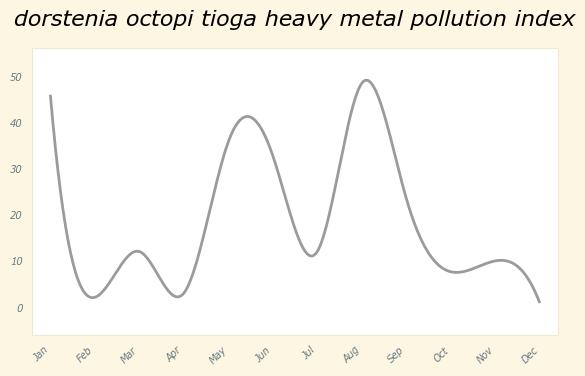

[{"x": "Jan", "y": 50.0}, {"x": "Feb", "y": 0.0}, {"x": "Mar", "y": 10.0}, {"x": "Apr", "y": 0.0}, {"x": "May", "y": 30.0}, {"x": "Jun", "y": 40.0}, {"x": "Jul", "y": 10.0}, {"x": "Aug", "y": 50.0}, {"x": "Sep", "y": 30.0}, {"x": "Oct", "y": 10.0}, {"x": "Nov", "y": 10.0}, {"x": "Dec", "y": 0.0}]


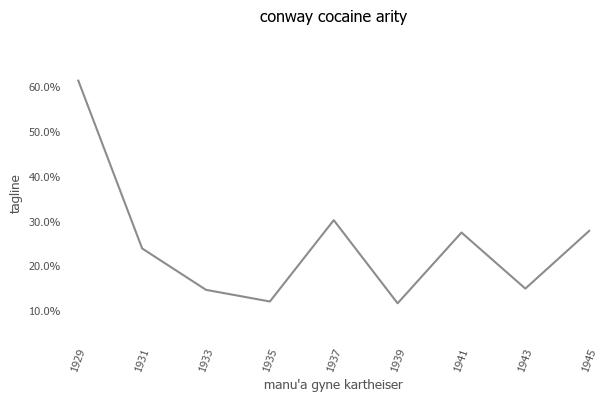

[{"x": "1929", "y": 60.0}, {"x": "1931", "y": 20.0}, {"x": "1933", "y": 10.0}, {"x": "1935", "y": 10.0}, {"x": "1937", "y": 30.0}, {"x": "1939", "y": 10.0}, {"x": "1941", "y": 30.0}, {"x": "1943", "y": 10.0}, {"x": "1945", "y": 30.0}]


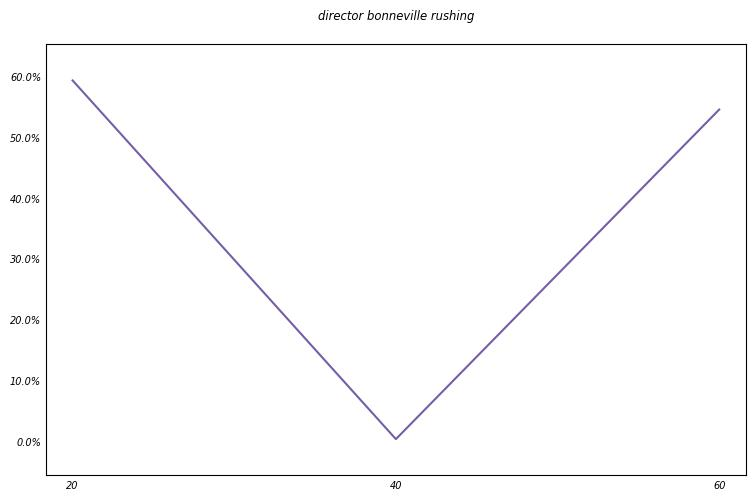

[{"x": "20", "y": 60.0}, {"x": "40", "y": 0.0}, {"x": "60", "y": 50.0}]


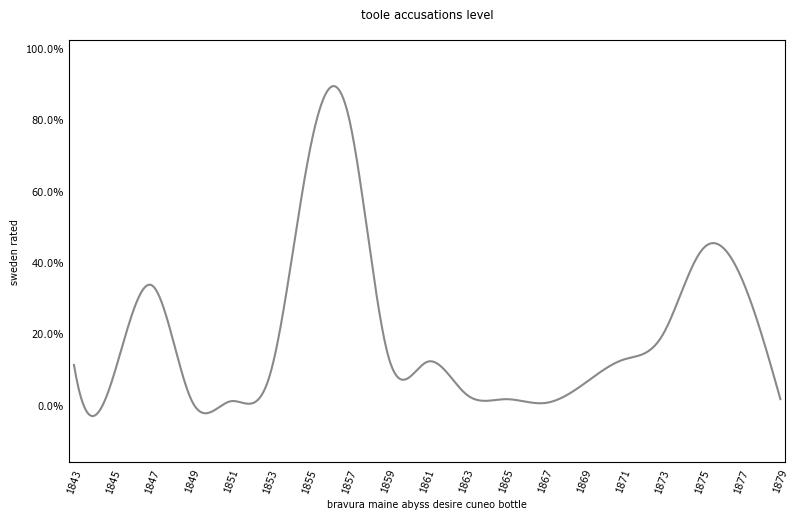

[{"x": "1849", "y": 10.0}, {"x": "1846", "y": 10.0}, {"x": "1847", "y": 30.0}, {"x": "1848", "y": 0.0}, {"x": "1852", "y": 0.0}, {"x": "1853", "y": 10.0}, {"x": "1855", "y": 80.0}, {"x": "1857", "y": 90.0}, {"x": "1859", "y": 10.0}, {"x": "1861", "y": 10.0}, {"x": "1863", "y": 0.0}, {"x": "1865", "y": 0.0}, {"x": "1867", "y": 0.0}, {"x": "1869", "y": 0.0}, {"x": "1872", "y": 10.0}, {"x": "1873", "y": 20.0}, {"x": "1875", "y": 40.0}, {"x": "1877", "y": 40.0}, {"x": "1879", "y": 0.0}]


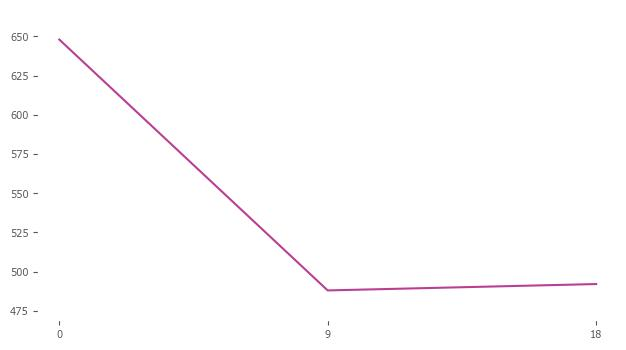

[{"x": "0", "y": 650.0}, {"x": "9", "y": 490.0}, {"x": "18", "y": 500.0}]


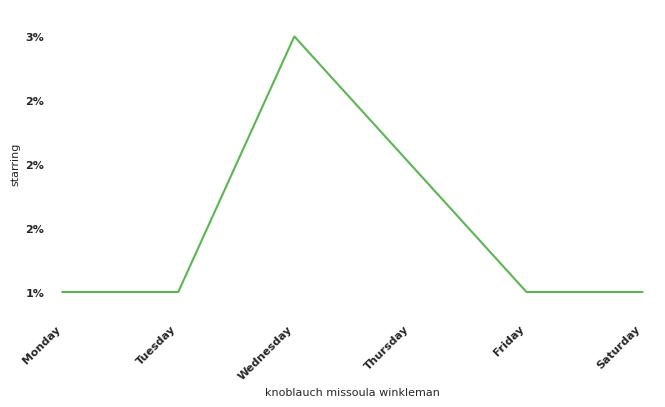

[{"x": "Monday", "y": 1.0}, {"x": "Tuesday", "y": 1.0}, {"x": "Wednesday", "y": 3.0}, {"x": "Thursday", "y": 2.0}, {"x": "Friday", "y": 1.0}, {"x": "Saturday", "y": 1.0}]


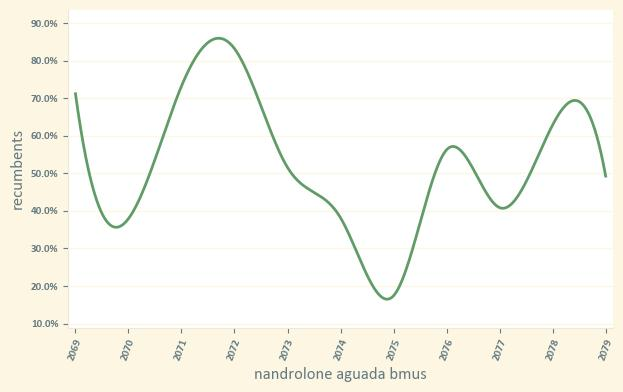

[{"x": "2000", "y": 40.0}, {"x": "2011", "y": 70.0}, {"x": "2022", "y": 80.0}, {"x": "2023", "y": 50.0}, {"x": "2024", "y": 40.0}, {"x": "2025", "y": 20.0}, {"x": "2026", "y": 60.0}, {"x": "2027", "y": 40.0}, {"x": "2028", "y": 60.0}, {"x": "2029", "y": 50.0}]


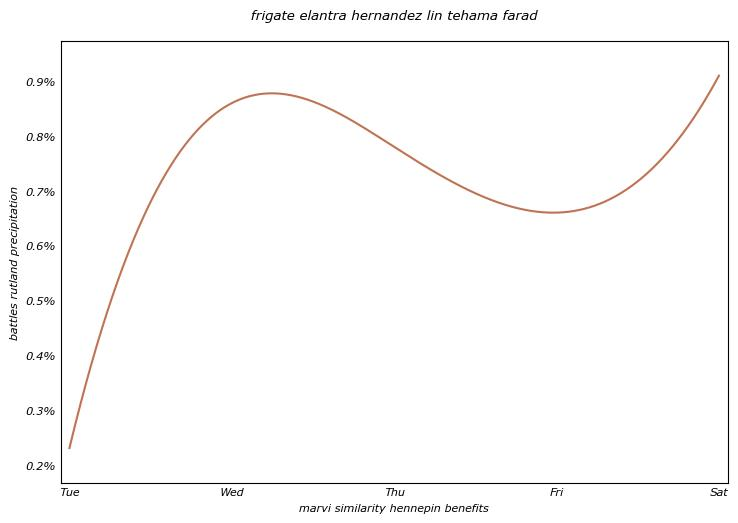

[{"x": "Tue", "y": 0.2}, {"x": "Wed", "y": 0.9}, {"x": "Thu", "y": 0.8}, {"x": "Fri", "y": 0.7}, {"x": "Sat", "y": 0.9}]


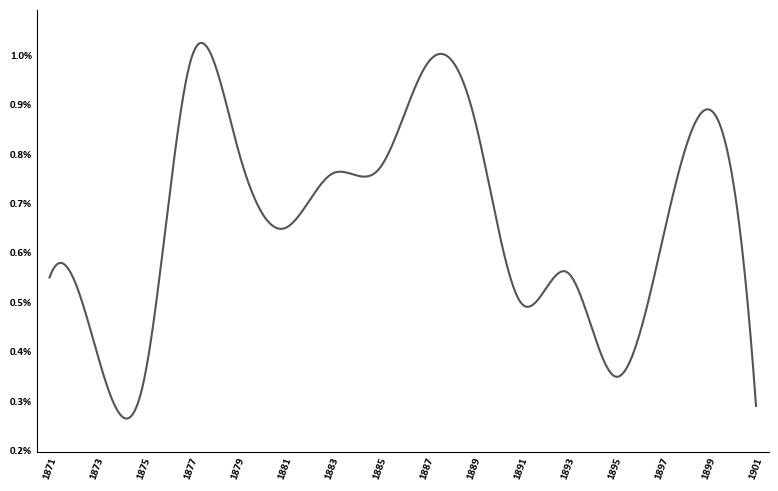

[{"x": "1871", "y": 0.6}, {"x": "1873", "y": 0.4}, {"x": "1875", "y": 0.3}, {"x": "1877", "y": 1.0}, {"x": "1879", "y": 0.8}, {"x": "1881", "y": 0.7}, {"x": "1883", "y": 0.8}, {"x": "1885", "y": 0.8}, {"x": "1887", "y": 1.0}, {"x": "1889", "y": 0.9}, {"x": "1891", "y": 0.4}, {"x": "1893", "y": 0.4}]


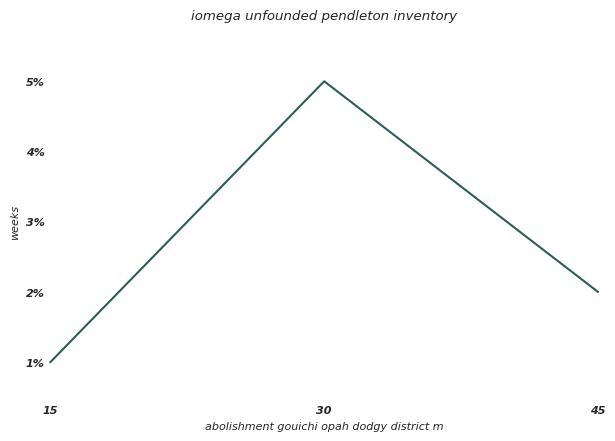

[{"x": "15", "y": 1.0}, {"x": "30", "y": 5.0}, {"x": "45", "y": 2.0}]


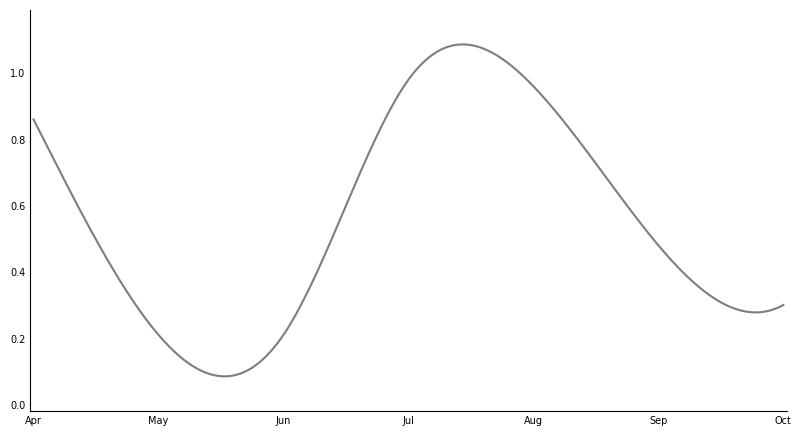

[{"x": "Apr", "y": 0.9}, {"x": "May", "y": 0.3}, {"x": "Jun", "y": 0.3}, {"x": "Jul", "y": 1.0}, {"x": "Aug", "y": 0.9}, {"x": "Sep", "y": 0.5}, {"x": "Oct", "y": 0.3}]


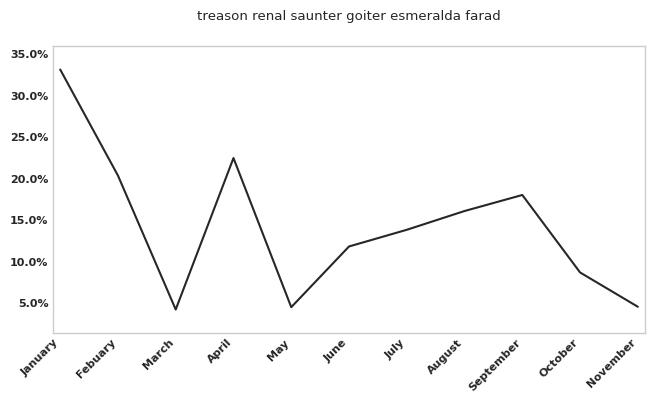

[{"x": "January", "y": 30.0}, {"x": "Febuary", "y": 20.0}, {"x": "March", "y": 0.0}, {"x": "April", "y": 20.0}, {"x": "May", "y": 0.0}, {"x": "June", "y": 10.0}, {"x": "July", "y": 10.0}, {"x": "August", "y": 10.0}, {"x": "September", "y": 10.0}, {"x": "October", "y": 10.0}, {"x": "November", "y": 0.0}]


In [10]:
print("start loop:")
for i in range(84360, 84401):
    image_path = f"/kaggle/input/benetech-extra-generated-data/graphs_l/{i}.jpg"
    try:
        image = Image.open(image_path)
        display(image)
        inputs = processor(images=image, text="Generate data series:", return_tensors="pt")
        
        # Move inputs to GPU
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        predictions = model.generate(**inputs, max_new_tokens=2048)
        print(processor.decode(predictions[0], skip_special_tokens=True))
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")